# The Advantage of Being Small - A Model For Individual Investors

## Introduction

Equity markets consist of some of the most studied data in the world. With millions invested into research, and computational tools beyond what's accessible to the average individual, it's not hard to see that an individual investor doing their own analysis will have a tough time outperforming. Currently, I see two paths to success:

1. **Find a strategy the institutions haven't:** while possible, this is unlikely to happen considering the disparity in resources spent on the problem. You'd have to be incredibly lucky, and even still it's probably only a matter of time before an institution catches on, at which point any alpha is lost.


2. **Find a strategy that institutions can't implement:** while the large amount of resources gives institutions ample opportunity, they also impose limitations. In particular, investing large amounts of capital has an impact on the market by moving equity prices and as a result signalling the rest of the market. This effect is especially pronounced in smaller caps. Moving large blocks of stock can be difficult and imprecise. 

The second point presents an opportunity, and is the basis for this project. 

Imagine a stock with a 500m market cap, that has been choppy for the past two years, moving cyclically between \\$4.50 and \\$5.50. An institution sets a buy price at \\$5.00 and sell at \\$5.10, hoping to lock in a 2\% gain every trade. Putting in an order to buy 100k shares at \\$5.00 will likely settle in blocks. Depending on the liquidity of the stock, executing such a large order will push up the stock price. In all likelihood, some blocks will settle at \\$5.00, some at \\$5.01... etc. Selling those 100k shares will have the opposite effect, pushing down the price during execution of the order. The result is far from the 2\% expected return (and even has the potential to be negative depending on how much the order moves the stock price). Buying 100 shares; however, will likely settle in a single block, and thus face no such issues. 

### Methodology

This project will follow the following framework:

1. Retrieve stock price data from the web using the yfinance package.


2. Design functions to:

    a) Filter stocks whose price has stayed within a given range for a given amount of time. 
    
    b) Backtest to find optimal buy and sell price of the given stock for iterative buys/sells within the given window.
    
    c) Calculate future returns given the optimal buy and sell price above.


3. Optimize parameters to improve filtering (remove stocks with negative future returns). 


4. Benchmark performance against SPY. 


I want to address the issue of relying on backtesting to predict future stock returns. The goal of this project is to find stocks that have been trading within a fixed range for an extended period of time, with the assumption that that will continue. Of course, not all stocks will continue to trade in the same pattern. However, by optimizing filters and implementing a tight stop, my hypothesis is that the success stories can outweigh those that don't. 

Like any other predictive model, overfitting to the training data by tuning the model parameters too specifically to the backtest can easily result in poorer actual returns. In this project, I have aimed to strike a balance between fine-tuning the model and avoiding overfitting, but it remains a concern that needs to be acknowledged.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
#from datetime import date, datetime, timedelta
from pandas.tseries.offsets import QuarterEnd
import matplotlib.pyplot as plt

## 1. Retrieve stock price data

To optimize the runtime and avoid unnecessary data downloads, I decided to generate a CSV file containing the price data for all the required tickers. This approach proved beneficial, particularly when tuning the model's parameters as it significantly reduced the runtime. Additionally, since I had to access data from the same tickers repeatedly, using a CSV file ensured data consistency and eliminated any concerns of discrepancies caused by downloading data multiple times.

Seperate CSVs were created for closing, high, and low prices. 

In [215]:
#create CSVs to store price data as opposed to downloading it throughout (much faster since I will be accessing
#.  data from the same tickers repeatedly)
start_date = datetime.date(2018,1,1)
end_date = datetime.date(2023,4,1)

tickers = pd.read_csv('/Users/kaigroden-gilchrist/Downloads/Personal_Project/SuccessiveSmallGains/' + 
                      'Equity-market-analysis/tickers.csv')
tickers = tickers.rename(columns = {"A": "Ticker"})
tickers = tickers["Ticker"]

closing_price_data = pd.DataFrame()
high_price_data = pd.DataFrame()
low_price_data = pd.DataFrame()

downloaded_tickers = []

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, interval="1d", progress=False)
        
    closing_price_data = pd.concat([closing_price_data, data['Close']], axis=1)
    high_price_data = pd.concat([high_price_data, data['High']], axis=1)
    low_price_data = pd.concat([low_price_data, data['Low']], axis=1)
    
closing_price_data.columns = tickers.values
high_price_data.columns = tickers.values
low_price_data.columns = tickers.values

closing_price_data.to_csv('/Users/kaigroden-gilchrist/Downloads/Personal_Project/SuccessiveSmallGains/' + 
                          'Equity-market-analysis/closing_price_data.csv', index=True)

high_price_data.to_csv('/Users/kaigroden-gilchrist/Downloads/Personal_Project/SuccessiveSmallGains/' + 
                          'Equity-market-analysis/high_price_data.csv', index=True)

low_price_data.to_csv('/Users/kaigroden-gilchrist/Downloads/Personal_Project/SuccessiveSmallGains/' + 
                          'Equity-market-analysis/low_price_data.csv', index=True)


1 Failed download:
- ANAC: No data found, symbol may be delisted

1 Failed download:
- CR: Data doesn't exist for startDate = 1514782800, endDate = 1680321600

1 Failed download:
- FRC: Data doesn't exist for startDate = 1514782800, endDate = 1680321600

1 Failed download:
- MSGE: Data doesn't exist for startDate = 1514782800, endDate = 1680321600

1 Failed download:
- RFP: No data found, symbol may be delisted

1 Failed download:
- CINC: No data found, symbol may be delisted

1 Failed download:
- COUP: No data found, symbol may be delisted

1 Failed download:
- COWN: No data found, symbol may be delisted

1 Failed download:
- DCRD: No data found, symbol may be delisted

1 Failed download:
- FTAA: No data found, symbol may be delisted

1 Failed download:
- KAII: No data found, symbol may be delisted

1 Failed download:
- MKSI: No data found for this date range, symbol may be delisted

1 Failed download:
- MKTX: No data found for this date range, symbol may be delisted

1 Failed downlo

The data is then cleaned and loaded below. 

In [12]:
#since csv can't store axis, need to reset it
price_data = pd.read_csv('/Users/kaigroden-gilchrist/Downloads/Personal_Project/SuccessiveSmallGains/Equity-ma' \
                      'rket-analysis/price_data.csv')
price_data = price_data.set_index("Unnamed: 0")
price_data = price_data.rename_axis("Date")

price_data

,AA,AAC,AAN,AAP,AAT,AB,ABB,ABBV,ABC,ABEV,...,ZING,ZION,ZLAB,ZM,ZNTL,ZS,ZT,ZUMZ,ZYME,ZYXI
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00,55.169998,NaN,NaN,106.089996,38.160000,25.200001,27.020000,98.410004,94.040001,6.61,...,NaN,50.700001,22.260000,NaN,NaN,NaN,NaN,20.000000,7.933,3.009091
2018-01-03 00:00:00,54.500000,NaN,NaN,107.050003,37.820000,25.450001,27.219999,99.949997,94.389999,6.65,...,NaN,50.639999,22.350000,NaN,NaN,NaN,NaN,20.500000,7.965,3.000000
2018-01-04 00:00:00,54.700001,NaN,NaN,111.000000,37.119999,25.850000,27.450001,99.379997,94.180000,6.64,...,NaN,50.849998,22.100000,NaN,NaN,NaN,NaN,22.950001,8.430,2.954545
2018-01-05 00:00:00,54.090000,NaN,NaN,112.180000,37.139999,26.200001,27.629999,101.110001,95.320000,6.67,...,NaN,50.869999,22.809999,NaN,NaN,NaN,NaN,22.549999,8.400,2.863636
2018-01-08 00:00:00,55.000000,NaN,NaN,111.389999,37.220001,26.700001,27.600000,99.489998,96.900002,6.62,...,NaN,50.619999,22.980000,NaN,NaN,NaN,NaN,23.000000,8.310,2.909091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27 00:00:00,40.119999,10.325,9.26,114.739998,17.270000,34.860001,32.139999,157.539993,156.690002,2.66,...,10.30,29.330000,32.639999,68.570000,17.660000,111.870003,10.120,17.209999,8.100,11.380000
2023-03-28 00:00:00,40.529999,10.350,9.22,115.739998,17.540001,35.430000,32.340000,158.250000,158.000000,2.78,...,10.28,29.950001,33.840000,68.540001,16.920000,110.250000,10.175,17.389999,8.070,11.710000
2023-03-29 00:00:00,40.939999,10.330,9.03,117.550003,18.000000,35.689999,32.799999,158.000000,158.970001,2.86,...,10.27,31.040001,35.040001,70.599998,17.600000,110.699997,10.130,17.730000,8.640,11.750000


Given my hypothesis that this strategy would perform better on smaller market cap stocks, I divided the price data into three groups based on market cap: small, mid, and large. This allowed me to test the strategy's effectiveness across different market cap categories. 

In [88]:
market_cap_dict = {}

for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        mcap = stock.fast_info['marketCap']
        market_cap_dict.update({ticker:mcap})
    except: KeyError #ignore tickers with no market cap available

In [196]:
# create dicts of tickers for each market cap
small_caps_dict = {k: v for k, v in market_cap_dict.items() if v < 2_000_000_000}
mid_caps_dict = {k: v for k, v in market_cap_dict.items() if 2_000_000_000 <= v <= 10_000_000_000}
large_caps_dict = {k: v for k, v in market_cap_dict.items() if v > 10_000_000_000}

# retrieve the tickers (keys) for each dict
small_cap_tickers = small_caps_dict.keys()
mid_cap_tickers = mid_caps_dict.keys()
large_cap_tickers = large_caps_dict.keys()

# filter the original price data for only the tickers with that market cap
small_cap_price_data = price_data[small_cap_tickers]
mid_cap_price_data = price_data[mid_cap_tickers]
large_cap_price_data = price_data[large_cap_tickers]

I also created a dataframe with both small and mid cap stocks, in the event that both work successfully. 

In [197]:
small_mid_price_data = pd.concat([small_cap_price_data, mid_cap_price_data], axis=1)

## 2. Design functions

### 2a. Filter stocks

The first function needs to filter stocks to keep only those with minimal variability. It does so by ensuring the price stays within a specified range of the mean within the given window.  

In [15]:
model_start_date = datetime.date(2019,3,1) 

def min_var_filter(price_data, var=0.1, model_start_date=model_start_date, period=200):
    
    """
    Return dict of {tickers:price adjusted stdev} for stocks whose price stays within var% of of the mean price
        in period days prior to the model_start_days.
        
    If max/min price too high/low set var to -1.
    Else find var to make sure price isn't TOO stable.

    """
    # set date range
    start_date = str(model_start_date - datetime.timedelta(period))
    end_date = str(model_start_date)
    
    # retrieve data and drop nan
    stock_data = price_data.loc[start_date:end_date]
    nan_cols = stock_data.columns[stock_data.iloc[0].isna()]
    stock_data = stock_data.drop(columns=nan_cols)
    
    var_dict = {}

    def calc_var(closing_price_data, column):
        """
        If the given ticker's max and min price is within var% of the mean, return it and the price adjusted
            deviation. 
        Else return the ticker and -1. 
        """
        ticker = column.name

        avg_close = np.mean(closing_price_data)
        max_close = np.max(closing_price_data)
        min_close = np.min(closing_price_data)

        upper_bound = (1+var)*avg_close
        lower_bound = (1-var)*avg_close

        # check prices
        # if price stays within bounds, calculate variability
        if (max_close > upper_bound) or (min_close < lower_bound):
            pv = -1
        else:         
            closing_std_dev = np.std(closing_price_data) 
            variability = closing_std_dev / avg_close #price adjusted deviation
            pv = variability

        return (ticker, pv)

    # use dictionary comprehension to filter out negative values
    var_dict = {key: val for key, val in [calc_var(stock_data[col_name], stock_data[col_name]) 
                                          for col_name in stock_data.columns] if val >= 0}

    return var_dict


### 2b. Backtest to find optimal buy and sell price

For each stock found above, we'll do a backtest to find the buy and sell prices that maximize returns over the given period. 

In [16]:
def back_calculate_returns(list_of_stocks, start_date, end_date):
    """
    Print the optimal buy and sell price of each stock in the given list over the given range
    Also gives total % returns over that period
    """
    
    returns = {}
    
    # need to specify global since vectorizing, otherwise error for calling variables before they're defined
    global owned
    global max_profit
    global best_sell
    global best_buy

    for i, stock in enumerate(list_of_stocks):
        info = yf.download(stock, start=start_date, end=end_date, progress=False)[["High", "Low"]]

        info = info.round(2)

        owned = False
        max_profit = 0.
        best_buy = 0.
        best_sell = 0.

        min_low = np.min(info["Low"])
        max_high = np.max(info["High"])

        # need this to prevent ValueError from weird values
        if min_low > 20:
            increment = min_low / 100
        else:
            increment = 0.1
            
        #wrapping in try/catch to stop occasional ValueErrors. Not sure on cause but infrequent enough to ignore
        #.  for now. 
        #.  Can get ValErr when assigning buy_prices or buy_vec, hence the long try statement
        try: 
            buy_prices = np.arange(min_low, max_high, increment)
            
            def buy(buy_price):

                global owned
                global max_profit
                global best_sell
                global best_buy

                sell_prices = np.arange(buy_price, max_high, increment)

                def sell(sell_price):
                    global owned
                    global max_profit
                    global best_sell
                    global best_buy

                    profit = 0.

                    for index, row in info.iterrows():
                        if (owned):
                            if (row["High"] >= sell_price):
                                profit += (sell_price - buy_price)
                                owned = False
                        else:
                            if (row["Low"] <= buy_price):
                                owned = True

                        if (profit > max_profit):
                            max_profit = round(profit, 2)
                            best_sell = round(sell_price, 2)
                            best_buy = round(buy_price, 2)

                sell_vec = np.vectorize(sell)
                sell_vec(sell_prices)

            buy_vec = np.vectorize(buy)
            buy_vec(buy_prices)
            try:
                percent_return = max_profit / best_buy * 100 
            except ZeroDivisionError:
                percent_return = 0
                
        except ValueError:
            max_profit = 0
            best_sell = 0
            best_buy = 0
            percent_return = 0

        print(f"The profit for {stock} is {max_profit} at buy price: {best_buy} and sell price: {best_sell}")
        print(f"That equates to a {percent_return}% return")
        
        #only include stocks with more than 2 buys and sells to make optimal profits in the returned dict
        if (max_profit > (best_sell - best_buy)*2):
            returns.update({stock : {"buy_price" : best_buy, "sell_price" : best_sell, 
                "min_low" : min_low, "max_high" : max_high}})           

    return returns


In [17]:
def front_calculate_returns(dict_of_stocks, start_date, end_date):
    """
    Front calculate returns using given dict with key: ticker vals: buy/sell prices, backwards looking 
       max high/min low 
    Sell out if price goes above max high/min low
    """
    
    global owned
    
    avg_returns_list = []

    for ticker in dict_of_stocks:
        
        prices = dict_of_stocks[ticker]
        buy_price = prices["buy_price"]
        sell_price = prices["sell_price"]
        min_low = prices["min_low"]
        max_high = prices["max_high"]
        
        info = yf.download(ticker, start=start_date, end=end_date, progress=False)[["High", "Low"]]

        info = info.round(2)

        owned = False
        
        profit = 0.

        for index, row in info.iterrows():
            #break if you leave the bounds of the training data
            if (row["Low"] < min_low):
                if (owned):
                    profit += row["Low"] - buy_price
                break
            #removed exit on upside out of bounds
                
            if (owned):
                if (row["High"] >= sell_price):
                    profit += (sell_price - buy_price)
                    owned = False
                # sell at end date if still owned
                elif (index == info.index[-1]):
                    profit += (row["Low"] - buy_price)
                    owned = False
            else:
                if (row["Low"] <= buy_price):
                    owned = True

        percent_return = profit / buy_price * 100

        print(f"The profit for {ticker} is {profit}")
        print(f"That equates to a {percent_return}% return")
        
        avg_returns_list.append(percent_return)
    
    equal_weight_avg_return = np.mean(avg_returns_list)

    print (f"The equal weight average returns are: {equal_weight_avg_return}")
    
    return equal_weight_avg_return

In [18]:
test_dates = pd.period_range(start='2018-12-31', end='2022-12-31', freq='Q').strftime('%Y-%m-%d').tolist()

extracted_date = datetime.datetime.strptime(test_dates[0], '%Y-%m-%d')
model_start_date = datetime.date(extracted_date.year, extracted_date.month, extracted_date.day)
print(model_start_date)

2018-12-31


## Single method for cumulative returns

In [19]:
test_dates = pd.period_range(start='2018-12-31', end='2022-12-31', freq='Q').strftime('%Y-%m-%d').tolist()

def list_of_returns_calc(price_data, dates, back_days, front_days):
    
    rets = []
    
    for date in dates:
        extracted_date = datetime.datetime.strptime(date, '%Y-%m-%d')
        model_start_date = datetime.date(extracted_date.year, extracted_date.month, extracted_date.day)
        print(model_start_date)
        
        var_dict = min_var_filter(price_data, var=0.1, model_start_date=model_start_date, period=back_days)
        ticker_list = list(var_dict.keys())
        print(ticker_list)
        
        start_date = str(model_start_date - datetime.timedelta(back_days))
        end_date = str(model_start_date)
        back_returns = back_calculate_returns(ticker_list, start_date, end_date)
        
        start_date = str(model_start_date) 
        end_date = str(model_start_date + datetime.timedelta(front_days) )
        rets.append(front_calculate_returns(back_returns, start_date, end_date))
        
    print(rets)
    return rets

In [20]:
test_dates = pd.period_range(start='2018-12-31', end='2022-12-31', freq='Q').strftime('%Y-%m-%d').tolist()

def list_of_returns_calc(price_data, var, dates, back_days, front_days):
    
    rets = []
    
    for date in dates:
        extracted_date = datetime.datetime.strptime(date, '%Y-%m-%d')
        model_start_date = datetime.date(extracted_date.year, extracted_date.month, extracted_date.day)
        print(model_start_date)
        
        var_dict = min_var_filter(price_data, var=var, model_start_date=model_start_date, period=back_days)
        ticker_list = list(var_dict.keys())
        print(ticker_list)
        
        start_date = str(model_start_date - datetime.timedelta(back_days))
        end_date = str(model_start_date)
        back_returns = back_calculate_returns(ticker_list, start_date, end_date)
        
        start_date = str(model_start_date) 
        end_date = str(model_start_date + datetime.timedelta(front_days) )
        rets.append(front_calculate_returns(back_returns, start_date, end_date))
        
    print(rets)
    return rets

In [21]:
import math
def cum_ret(list_of_list_of_rets):
    for i in range(len(list_of_list_of_rets)):
        list_i = list_of_list_of_rets[i]
        newi = []
        for x in list_i:
            if not math.isnan(x):
                newi.append(x)
        cum_ret = 1
        for x in newi:
            cum_ret *= (1+ x/100)
        cum_ret = (cum_ret - 1) * 100
        print(f"total cumulatic returns = {cum_ret}%")

In [152]:
#testing with 2 buys but also 25+% profit to add to dict
def back_calculate_returns(list_of_stocks, start_date, end_date):
    """
    Print the optimal buy and sell price of each stock in the given list over the given range
    Also gives total % returns over that period
    """
    
    returns = {}
    
    # need to add these globals since vectorizing, otherwise the program complains that it's calling  
    #.  variables before they're defined
    global owned
    global max_profit
    global best_sell
    global best_buy

    for i, stock in enumerate(list_of_stocks):
        info = yf.download(stock, start=start_date, end=end_date, progress=False)[["High", "Low"]]

        info = info.round(2)

        owned = False
        max_profit = 0.
        best_buy = 0.
        best_sell = 0.

        min_low = np.min(info["Low"])
        max_high = np.max(info["High"])

        # need this to prevent ValueError from weird values
        if min_low > 20:
            increment = min_low / 100
        else:
            increment = 0.1
            
        #wrapping in try/catch to stop occasional ValueErrors. Not sure on cause but infrequent enough to ignore
        #.  for now. 
        #.  Can get ValErr when assigning buy_prices or buy_vec, hence the long try statement
        try: 
            buy_prices = np.arange(min_low, max_high, increment)
            
            def buy(buy_price):

                global owned
                global max_profit
                global best_sell
                global best_buy

                sell_prices = np.arange(buy_price, max_high, increment)

                def sell(sell_price):
                    global owned
                    global max_profit
                    global best_sell
                    global best_buy

                    profit = 0.

                    for index, row in info.iterrows():
                        if (owned):
                            if (row["High"] >= sell_price):
                                profit += (sell_price - buy_price)
                                owned = False
                        else:
                            if (row["Low"] <= buy_price):
                                owned = True

                        if (profit > max_profit):
                            max_profit = round(profit, 2)
                            best_sell = round(sell_price, 2)
                            best_buy = round(buy_price, 2)

                sell_vec = np.vectorize(sell)
                sell_vec(sell_prices)

            buy_vec = np.vectorize(buy)
            buy_vec(buy_prices)
            try:
                percent_return = max_profit / best_buy * 100 
            except ZeroDivisionError:
                percent_return = 0
                
        except ValueError:
            max_profit = 0
            best_sell = 0
            best_buy = 0
            percent_return = 0

        print(f"The profit for {stock} is {max_profit} at buy price: {best_buy} and sell price: {best_sell}")
        print(f"That equates to a {percent_return}% return")
        
        #only include stocks with more than 3 buys and sells to make optimal profits in the returned dict
        if (max_profit > (best_sell - best_buy)*2 and percent_return >= 25 and 
            percent_return <= 60):
            returns.update({stock : {"buy_price" : best_buy, "sell_price" : best_sell, 
                "min_low" : min_low, "max_high" : max_high}})           

    return returns


In [171]:
sc_high_profit_back_150_front_90_var_0075 = list_of_returns_calc(small_cap_price_data, 0.075, test_dates, 150, 90)

2018-12-31
['ACEL', 'AFB', 'AIV', 'BBN', 'BFK', 'BFZ', 'BHK', 'BLE', 'BTT', 'BTZ', 'CTOS', 'EFC', 'EVN', 'GB', 'GBAB', 'GHY', 'GIM', 'GPMT', 'IIM', 'IQI', 'KREF', 'KTF', 'LEO', 'MHN', 'MIN', 'MIY', 'MMD', 'MQY', 'MUA', 'MUC', 'MUI', 'MUJ', 'MVF', 'MYD', 'MYI', 'MYN', 'NAC', 'NAN', 'NBB', 'NID', 'NKX', 'NMZ', 'NQP', 'NRK', 'NUV', 'NXJ', 'NXP', 'NZF', 'PACK', 'PML', 'PMM', 'PMO', 'SGU', 'SPCE', 'UTL', 'VCV', 'VGM', 'VKQ', 'VMO', 'WIW', 'AHCO', 'BIOX', 'BROG', 'GCBC', 'HIFS', 'HPK', 'IGIC', 'NKLA', 'NRC', 'ORGO', 'OSW', 'RPAY', 'TH', 'THRY', 'WSBF']
The profit for ACEL is 0.5 at buy price: 9.84 and sell price: 10.34
That equates to a 5.08130081300813% return
The profit for AFB is 0.9 at buy price: 11.78 and sell price: 12.68
That equates to a 7.6400679117147705% return
The profit for AIV is 0.8 at buy price: 5.5 and sell price: 6.3
That equates to a 14.545454545454547% return
The profit for BBN is 2.6 at buy price: 19.59 and sell price: 22.19
That equates to a 13.272077590607454% return
T

The profit for ORGO is 1.3 at buy price: 9.47 and sell price: 10.77
That equates to a 13.727560718057022% return
The profit for OSW is 0.3 at buy price: 9.75 and sell price: 10.05
That equates to a 3.0769230769230766% return
The profit for RPAY is 0.3 at buy price: 9.6 and sell price: 9.9
That equates to a 3.125% return
The profit for TH is 0.4 at buy price: 9.7 and sell price: 10.1
That equates to a 4.123711340206186% return
The profit for THRY is 0.9 at buy price: 10.0 and sell price: 10.9
That equates to a 9.0% return
The profit for WSBF is 2.4 at buy price: 16.6 and sell price: 17.0
That equates to a 14.457831325301203% return
The profit for GCBC is -0.5099999999999998
That equates to a -3.2380952380952364% return
The profit for NRC is 8.790000000000013
That equates to a 23.089046493301847% return
The equal weight average returns are: 9.925475627603305
2019-03-31
['ACEL', 'AFB', 'BFK', 'BFZ', 'BHK', 'BRW', 'BTT', 'BTZ', 'CIM', 'CTOS', 'DX', 'EFT', 'EVN', 'FRA', 'FSR', 'GB', 'GHY', 

The profit for WIW is 0.8 at buy price: 10.01 and sell price: 10.81
That equates to a 7.992007992007992% return
The profit for AHCO is 1.1 at buy price: 9.75 and sell price: 10.85
That equates to a 11.282051282051283% return
The profit for BROG is 0.3 at buy price: 9.66 and sell price: 9.96
That equates to a 3.1055900621118013% return
The profit for CFFN is 3.2 at buy price: 12.67 and sell price: 13.47
That equates to a 25.25651144435675% return
The profit for CLBK is 2.7 at buy price: 15.53 and sell price: 15.83
That equates to a 17.385705086928528% return
The profit for DGICA is 4.5 at buy price: 13.44 and sell price: 13.74
That equates to a 33.48214285714286% return
The profit for DJCO is 69.42 at buy price: 215.97 and sell price: 233.32
That equates to a 32.14335324350605% return
The profit for DSGR is 11.8 at buy price: 29.79 and sell price: 31.75
That equates to a 39.610607586438405% return
The profit for FCUV is 0.7 at buy price: 4.24 and sell price: 4.94
That equates to a 16.50

The profit for BRW is 0.6 at buy price: 9.48 and sell price: 9.78
That equates to a 6.329113924050632% return
The profit for BTT is 1.51 at buy price: 21.64 and sell price: 23.15
That equates to a 6.977818853974122% return
The profit for BTZ is 1.1 at buy price: 11.83 and sell price: 12.93
That equates to a 9.29839391377853% return
The profit for BUI is 2.44 at buy price: 21.13 and sell price: 21.74
That equates to a 11.547562707051586% return
The profit for BXMX is 1.4 at buy price: 13.0 and sell price: 13.2
That equates to a 10.769230769230768% return
The profit for CEM is 8.18 at buy price: 60.15 and sell price: 64.24
That equates to a 13.599334995843723% return
The profit for CII is 1.6 at buy price: 15.42 and sell price: 15.82
That equates to a 10.376134889753567% return
The profit for CIM is 2.0 at buy price: 18.7 and sell price: 19.2
That equates to a 10.695187165775401% return
The profit for CPF is 4.39 at buy price: 27.69 and sell price: 29.89
That equates to a 15.854098952690

The profit for JBGS is 6.07 at buy price: 38.72 and sell price: 41.76
That equates to a 15.676652892561984% return
The profit for JFR is 0.8 at buy price: 9.67 and sell price: 10.07
That equates to a 8.273009307135471% return
The profit for JPC is 1.0 at buy price: 8.89 and sell price: 9.89
That equates to a 11.248593925759279% return
The profit for JPI is 1.75 at buy price: 21.84 and sell price: 23.59
That equates to a 8.012820512820513% return
The profit for JPS is 0.9 at buy price: 8.57 and sell price: 9.47
That equates to a 10.501750291715286% return
The profit for JQC is 0.6 at buy price: 7.8 and sell price: 7.9
That equates to a 7.6923076923076925% return
The profit for JRI is 1.6 at buy price: 15.3 and sell price: 16.9
That equates to a 10.457516339869281% return
The profit for JRO is 0.8 at buy price: 9.63 and sell price: 10.03
That equates to a 8.307372793354102% return
The profit for KAMN is 18.24 at buy price: 57.49 and sell price: 63.57
That equates to a 31.72725691424595% 

The profit for TDF is 0 at buy price: 0 and sell price: 0
That equates to a 0% return
The profit for THQ is 1.8 at buy price: 16.32 and sell price: 18.12
That equates to a 11.029411764705882% return
The profit for THW is 1.3 at buy price: 11.89 and sell price: 13.19
That equates to a 10.933557611438182% return
The profit for TRTX is 1.8 at buy price: 19.6 and sell price: 19.8
That equates to a 9.183673469387754% return
The profit for TSLX is 3.0 at buy price: 19.66 and sell price: 20.26
That equates to a 15.25940996948118% return
The profit for TY is 3.04 at buy price: 25.6 and sell price: 26.62
That equates to a 11.875% return
The profit for UBA is 3.9 at buy price: 20.76 and sell price: 22.06
That equates to a 18.786127167630056% return
The profit for UBP is 2.8 at buy price: 16.85 and sell price: 17.25
That equates to a 16.617210682492576% return
The profit for USA is 0.8 at buy price: 5.6 and sell price: 6.4
That equates to a 14.285714285714288% return
The profit for UTZ is 0.7 at 

The profit for SLRC is 1.81 at buy price: 21.3 and sell price: 21.5
That equates to a 8.497652582159624% return
The profit for SRCE is 10.05 at buy price: 43.54 and sell price: 48.57
That equates to a 23.08222324299495% return
The profit for STBA is 9.49 at buy price: 37.62 and sell price: 40.79
That equates to a 25.225943646996278% return
The profit for SVC is 4.24 at buy price: 23.55 and sell price: 27.79
That equates to a 18.004246284501065% return
The profit for TCBK is 9.19 at buy price: 37.85 and sell price: 39.69
That equates to a 24.28005284015852% return
The profit for TCPC is 1.8 at buy price: 14.33 and sell price: 14.53
That equates to a 12.56106071179344% return
The profit for THRY is 0.3 at buy price: 10.35 and sell price: 10.65
That equates to a 2.898550724637681% return
The profit for TRS is 5.93 at buy price: 28.79 and sell price: 30.77
That equates to a 20.597429663077456% return
The profit for UVSP is 6.95 at buy price: 23.61 and sell price: 25.93
That equates to a 29

The profit for BTZ is 1.4 at buy price: 12.48 and sell price: 13.88
That equates to a 11.217948717948717% return
The profit for BXMX is 1.1 at buy price: 13.01 and sell price: 13.11
That equates to a 8.455034588777863% return
The profit for CII is 2.2 at buy price: 15.12 and sell price: 16.22
That equates to a 14.550264550264552% return
The profit for CIM is 2.4 at buy price: 18.1 and sell price: 20.5
That equates to a 13.259668508287293% return
The profit for CPF is 5.42 at buy price: 28.48 and sell price: 29.56
That equates to a 19.030898876404496% return
The profit for CTRE is 4.94 at buy price: 20.57 and sell price: 25.51
That equates to a 24.015556635877495% return
The profit for DFP is 2.36 at buy price: 23.57 and sell price: 25.93
That equates to a 10.012728044123884% return
The profit for DIAX is 2.2 at buy price: 16.8 and sell price: 17.9
That equates to a 13.095238095238097% return
The profit for DM is 0.4 at buy price: 9.61 and sell price: 10.01
That equates to a 4.162330905

The profit for JPI is 2.04 at buy price: 23.81 and sell price: 24.49
That equates to a 8.567828643427132% return
The profit for JPS is 0.9 at buy price: 8.99 and sell price: 9.89
That equates to a 10.011123470522804% return
The profit for JQC is 0.7 at buy price: 7.32 and sell price: 8.02
That equates to a 9.562841530054644% return
The profit for JRI is 1.8 at buy price: 16.51 and sell price: 17.41
That equates to a 10.902483343428225% return
The profit for JRO is 0.6 at buy price: 9.41 and sell price: 10.01
That equates to a 6.376195536663124% return
The profit for KREF is 1.6 at buy price: 19.72 and sell price: 20.12
That equates to a 8.113590263691686% return
The profit for KTF is 0.7 at buy price: 11.1 and sell price: 11.8
That equates to a 6.306306306306306% return
The profit for LADR is 1.8 at buy price: 15.85 and sell price: 17.65
That equates to a 11.35646687697161% return
The profit for LDP is 2.11 at buy price: 23.48 and sell price: 25.59
That equates to a 8.986371379897784% 

The profit for USA is 0.8 at buy price: 5.9 and sell price: 6.7
That equates to a 13.559322033898304% return
The profit for UTL is 10.0 at buy price: 56.66 and sell price: 61.66
That equates to a 17.649135192375574% return
The profit for UTZ is 0.6 at buy price: 9.75 and sell price: 10.35
That equates to a 6.153846153846153% return
The profit for VCV is 1.3 at buy price: 12.25 and sell price: 13.55
That equates to a 10.612244897959185% return
The profit for VGM is 1.0 at buy price: 12.25 and sell price: 13.25
That equates to a 8.16326530612245% return
The profit for VKQ is 0.9 at buy price: 11.99 and sell price: 12.89
That equates to a 7.506255212677231% return
The profit for VMO is 0.9 at buy price: 11.9 and sell price: 12.8
That equates to a 7.563025210084033% return
The profit for VVR is 0.4 at buy price: 4.13 and sell price: 4.33
That equates to a 9.685230024213077% return
The profit for WIW is 0.6 at buy price: 10.72 and sell price: 11.32
That equates to a 5.597014925373134% retur

The profit for PGC is 5.2 at buy price: 26.5 and sell price: 29.1
That equates to a 19.622641509433965% return
The profit for QQQX is 2.49 at buy price: 21.55 and sell price: 22.79
That equates to a 11.554524361948957% return
The profit for RBB is 6.0 at buy price: 19.08 and sell price: 19.68
That equates to a 31.44654088050315% return
The profit for RDWR is 3.89 at buy price: 22.87 and sell price: 26.76
That equates to a 17.009182334936597% return
The profit for ROIC is 3.0 at buy price: 17.06 and sell price: 18.56
That equates to a 17.58499413833529% return
The profit for SAFT is 18.02 at buy price: 93.72 and sell price: 98.23
That equates to a 19.22748612889458% return
The profit for SASR is 8.64 at buy price: 32.64 and sell price: 35.52
That equates to a 26.47058823529412% return
The profit for SBSI is 6.57 at buy price: 32.55 and sell price: 33.49
That equates to a 20.184331797235025% return
The profit for SHBI is 4.0 at buy price: 15.2 and sell price: 16.0
That equates to a 26.31

The profit for BCSF is 2.4 at buy price: 18.44 and sell price: 18.64
That equates to a 13.015184381778742% return
The profit for BCX is 1.0 at buy price: 7.55 and sell price: 8.05
That equates to a 13.245033112582782% return
The profit for BDJ is 1.1 at buy price: 8.63 and sell price: 9.73
That equates to a 12.746234067207416% return
The profit for BDN is 2.0 at buy price: 14.63 and sell price: 15.03
That equates to a 13.670539986329459% return
The profit for BFK is 1.0 at buy price: 13.76 and sell price: 14.26
That equates to a 7.267441860465117% return
The profit for BFZ is 0.6 at buy price: 13.34 and sell price: 13.94
That equates to a 4.497751124437781% return
The profit for BGB is 1.3 at buy price: 13.68 and sell price: 14.98
That equates to a 9.502923976608187% return
The profit for BGY is 0.6 at buy price: 5.27 and sell price: 5.87
That equates to a 11.385199240986719% return
The profit for BHK is 0.9 at buy price: 14.29 and sell price: 14.59
That equates to a 6.298110566829952%

The profit for HPI is 2.61 at buy price: 23.08 and sell price: 23.95
That equates to a 11.308492201039861% return
The profit for HPS is 1.6 at buy price: 19.02 and sell price: 19.22
That equates to a 8.412197686645637% return
The profit for HT is 3.8 at buy price: 13.4 and sell price: 15.3
That equates to a 28.35820895522388% return
The profit for HTD is 3.71 at buy price: 24.75 and sell price: 28.46
That equates to a 14.98989898989899% return
The profit for HTGC is 1.9 at buy price: 12.6 and sell price: 14.5
That equates to a 15.079365079365079% return
The profit for HYT is 1.0 at buy price: 10.3 and sell price: 11.3
That equates to a 9.70873786407767% return
The profit for IFN is 2.1 at buy price: 19.91 and sell price: 20.61
That equates to a 10.547463586137619% return
The profit for IGD is 0.5 at buy price: 5.83 and sell price: 6.33
That equates to a 8.576329331046312% return
The profit for IGR is 0.6 at buy price: 7.38 and sell price: 7.98
That equates to a 8.130081300813007% retur

The profit for PRA is 6.39 at buy price: 35.49 and sell price: 41.88
That equates to a 18.005071851225697% return
The profit for PTY is 2.1 at buy price: 16.81 and sell price: 18.91
That equates to a 12.492563950029746% return
The profit for RA is 1.7 at buy price: 21.21 and sell price: 22.91
That equates to a 8.015087223008015% return
The profit for RC is 3.0 at buy price: 15.55 and sell price: 16.55
That equates to a 19.292604501607716% return
The profit for RMM is 1.8 at buy price: 19.77 and sell price: 20.37
That equates to a 9.104704097116844% return
The profit for RMT is 0.9 at buy price: 7.61 and sell price: 8.51
That equates to a 11.826544021024967% return
The profit for RQI is 2.2 at buy price: 13.82 and sell price: 16.02
That equates to a 15.918958031837919% return
The profit for RVT is 2.2 at buy price: 13.19 and sell price: 14.29
That equates to a 16.67930250189538% return
The profit for RWT is 2.0 at buy price: 16.4 and sell price: 16.8
That equates to a 12.195121951219514

The profit for NYMT is 2.35 at buy price: 24.46 and sell price: 24.93
That equates to a 9.607522485690923% return
The profit for OBT is 3.79 at buy price: 27.05 and sell price: 30.84
That equates to a 14.011090573012938% return
The profit for OCSL is 2.4 at buy price: 15.4 and sell price: 15.6
That equates to a 15.584415584415584% return
The profit for OSIS is 26.05 at buy price: 93.98 and sell price: 107.01
That equates to a 27.718663545435195% return
The profit for QQQX is 2.58 at buy price: 21.52 and sell price: 24.1
That equates to a 11.988847583643123% return
The profit for RELL is 1.3 at buy price: 5.65 and sell price: 5.75
That equates to a 23.008849557522122% return
The profit for RMR is 11.55 at buy price: 45.79 and sell price: 47.07
That equates to a 25.223848001747108% return
The profit for ROIC is 2.6 at buy price: 17.09 and sell price: 18.39
That equates to a 15.21357519016969% return
The profit for SAFT is 15.92 at buy price: 93.76 and sell price: 96.41
That equates to a 

/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The profit for DM is 1.0 at buy price: 9.4 and sell price: 10.4
That equates to a 10.638297872340425% return
The profit for FREY is 1.6 at buy price: 9.55 and sell price: 9.75
That equates to a 16.75392670157068% return
The profit for FSR is 1.0 at buy price: 9.75 and sell price: 10.75
That equates to a 10.256410256410255% return
The profit for GB is 1.0 at buy price: 9.86 and sell price: 10.86
That equates to a 10.141987829614605% return
The profit for JBI is 1.5 at buy price: 9.7 and sell price: 10.0
That equates to a 15.463917525773196% return
The profit for ODV is 2.46 at buy price: 22.32 and sell price: 24.78
That equates to a 11.021505376344086% return
The profit for ADV is 2.5 at buy price: 10.7 and sell price: 11.2
That equates to a 23.364485981308412% return
The profit for AMYT is 0.5 at buy price: 7.9 and sell price: 8.4
That equates to a 6.329113924050632% return
The profit for ARKO is 2.2 at buy price: 9.02 and sell price: 11.22
That equates to a 24.39024390243903% return
T

/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['AEVA', 'AFB', 'BFZ', 'BHK', 'BME', 'BXMX', 'DLY', 'ETB', 'EVN', 'FINS', 'FRA', 'FREY', 'GBAB', 'GIM', 'HQH', 'HQL', 'IGD', 'IIM', 'IQI', 'IVT', 'JBI', 'JQC', 'KTF', 'MIN', 'MIY', 'MMD', 'MMU', 'MUI', 'MYN', 'NAC', 'NAN', 'NID', 'NKX', 'NQP', 'NRK', 'NXJ', 'RMM', 'THQ', 'THW', 'VCV', 'VGM', 'VKQ', 'VMO', 'ARKO', 'ARTNA', 'ASLE', 'ASTS', 'ATRI', 'AVPT', 'BLDE', 'GCMG', 'INDI', 'MVST', 'OBT', 'PRCH', 'PROC', 'THRY']
The profit for AEVA is 0.5 at buy price: 9.61 and sell price: 10.11
That equates to a 5.202913631633716% return
The profit for AFB is 1.6 at buy price: 12.44 and sell price: 14.04
That equates to a 12.861736334405146% return
The profit for BFZ is 1.9 at buy price: 12.23 and sell price: 14.13
That equates to a 15.53556827473426% return
The profit for BHK is 2.0 at buy price: 14.2 and sell price: 16.2
That equates to a 14.084507042253522% return
The profit for BME is 7.09 at buy price: 40.57 and sell price: 42.94
That equates to a 17.475967463643087% return
The profit for BXMX

The profit for BGB is 1.4 at buy price: 11.7 and sell price: 12.4
That equates to a 11.965811965811966% return
The profit for BHK is 1.2 at buy price: 15.47 and sell price: 15.87
That equates to a 7.756948933419521% return
The profit for BIT is 2.1 at buy price: 15.15 and sell price: 17.25
That equates to a 13.861386138613863% return
The profit for BLE is 2.7 at buy price: 14.54 and sell price: 15.44
That equates to a 18.569463548830814% return
The profit for BLW is 1.8 at buy price: 14.16 and sell price: 15.96
That equates to a 12.711864406779661% return
The profit for BRW is 0.6 at buy price: 8.4 and sell price: 9.0
That equates to a 7.142857142857142% return
The profit for BTT is 0.97 at buy price: 25.03 and sell price: 25.27
That equates to a 3.8753495805033955% return
The profit for BTZ is 1.3 at buy price: 13.66 and sell price: 14.96
That equates to a 9.51683748169839% return
The profit for CHCT is 19.71 at buy price: 45.56 and sell price: 49.51
That equates to a 43.2616330114135

The profit for PML is 1.7 at buy price: 12.95 and sell price: 14.65
That equates to a 13.12741312741313% return
The profit for PMM is 0.5 at buy price: 7.55 and sell price: 8.05
That equates to a 6.622516556291391% return
The profit for PMO is 1.1 at buy price: 12.63 and sell price: 13.73
That equates to a 8.709422011084719% return
The profit for PPT is 0.4 at buy price: 4.45 and sell price: 4.65
That equates to a 8.98876404494382% return
The profit for RA is 2.6 at buy price: 15.86 and sell price: 18.46
That equates to a 16.393442622950822% return
The profit for RMM is 1.6 at buy price: 16.51 and sell price: 18.11
That equates to a 9.691096305269534% return
The profit for SGU is 2.4 at buy price: 9.53 and sell price: 9.73
That equates to a 25.183630640083948% return
The profit for SOR is 7.0 at buy price: 36.05 and sell price: 37.8
That equates to a 19.417475728155342% return
The profit for VCV is 1.1 at buy price: 12.03 and sell price: 13.13
That equates to a 9.143807148794682% retur

The profit for NRK is 1.0 at buy price: 12.8 and sell price: 13.8
That equates to a 7.8125% return
The profit for NUV is 1.3 at buy price: 11.02 and sell price: 11.12
That equates to a 11.796733212341199% return
The profit for NXJ is 1.3 at buy price: 13.53 and sell price: 14.83
That equates to a 9.608277900960829% return
The profit for NZF is 1.8 at buy price: 14.72 and sell price: 16.52
That equates to a 12.228260869565217% return
The profit for PMM is 0.7 at buy price: 7.66 and sell price: 8.36
That equates to a 9.138381201044385% return
The profit for PMO is 1.2 at buy price: 12.71 and sell price: 13.91
That equates to a 9.44138473642801% return
The profit for PPT is 0.3 at buy price: 4.45 and sell price: 4.75
That equates to a 6.741573033707865% return
The profit for PTA is 2.21 at buy price: 25.04 and sell price: 25.29
That equates to a 8.825878594249202% return
The profit for RBOT is 0.9 at buy price: 9.6 and sell price: 10.5
That equates to a 9.375% return
The profit for RMM is

The profit for FPF is 2.3 at buy price: 22.95 and sell price: 25.25
That equates to a 10.021786492374728% return
The profit for FRA is 0.8 at buy price: 12.78 and sell price: 12.98
That equates to a 6.259780907668231% return
The profit for FSD is 1.0 at buy price: 14.74 and sell price: 15.74
That equates to a 6.7842605156037985% return
The profit for FTHY is 2.4 at buy price: 19.79 and sell price: 19.99
That equates to a 12.12733703890854% return
The profit for GBAB is 3.15 at buy price: 22.5 and sell price: 25.65
That equates to a 13.999999999999998% return
The profit for GHY is 1.3 at buy price: 14.46 and sell price: 15.76
That equates to a 8.990318118948824% return
The profit for GIM is 0.4 at buy price: 5.29 and sell price: 5.69
That equates to a 7.561436672967864% return
The profit for GRNT is 0.8 at buy price: 9.72 and sell price: 10.12
That equates to a 8.23045267489712% return
The profit for HIO is 0.4 at buy price: 4.91 and sell price: 5.31
That equates to a 8.146639511201629%

The profit for WIW is 1.3 at buy price: 11.92 and sell price: 13.22
That equates to a 10.906040268456376% return
The profit for CHI is 3.0 at buy price: 13.79 and sell price: 14.79
That equates to a 21.754894851341554% return
The profit for CHW is 2.4 at buy price: 9.94 and sell price: 10.24
That equates to a 24.14486921529175% return
The profit for CSGS is 10.65 at buy price: 45.13 and sell price: 47.26
That equates to a 23.598493241746066% return
The profit for CZFS is 8.71 at buy price: 54.46 and sell price: 63.17
That equates to a 15.993389643775249% return
The profit for EVLV is 2.0 at buy price: 9.81 and sell price: 10.81
That equates to a 20.38735983690112% return
The profit for GWRS is 7.5 at buy price: 16.31 and sell price: 17.81
That equates to a 45.98405885959534% return
The profit for HAIN is 7.87 at buy price: 42.51 and sell price: 44.08
That equates to a 18.51329099035521% return
The profit for LANDM is 2.01 at buy price: 26.16 and sell price: 27.16
That equates to a 7.68

The profit for BLW is 1.5 at buy price: 16.8 and sell price: 17.3
That equates to a 8.928571428571429% return
The profit for BME is 4.58 at buy price: 47.17 and sell price: 49.46
That equates to a 9.709561161755353% return
The profit for BOE is 1.1 at buy price: 11.68 and sell price: 12.78
That equates to a 9.417808219178085% return
The profit for BRMK is 1.6 at buy price: 10.03 and sell price: 10.83
That equates to a 15.952143569292126% return
The profit for BRW is 0.4 at buy price: 9.04 and sell price: 9.44
That equates to a 4.424778761061948% return
The profit for BTT is 1.01 at buy price: 25.51 and sell price: 26.02
That equates to a 3.9592316738533904% return
The profit for BTZ is 1.2 at buy price: 14.73 and sell price: 15.93
That equates to a 8.146639511201629% return
The profit for BUI is 4.5 at buy price: 26.0 and sell price: 26.75
That equates to a 17.307692307692307% return
The profit for BXMX is 1.6 at buy price: 14.01 and sell price: 14.81
That equates to a 11.4204139900071

The profit for JFR is 0.6 at buy price: 9.56 and sell price: 10.16
That equates to a 6.2761506276150625% return
The profit for JPC is 0.5 at buy price: 9.51 and sell price: 10.01
That equates to a 5.257623554153523% return
The profit for JPI is 1.25 at buy price: 24.99 and sell price: 26.24
That equates to a 5.002000800320128% return
The profit for JPS is 0.4 at buy price: 9.61 and sell price: 10.01
That equates to a 4.162330905306972% return
The profit for JQC is 0.4 at buy price: 6.52 and sell price: 6.72
That equates to a 6.134969325153375% return
The profit for JRI is 2.0 at buy price: 15.9 and sell price: 16.3
That equates to a 12.578616352201259% return
The profit for JRO is 0.5 at buy price: 9.43 and sell price: 9.93
That equates to a 5.302226935312832% return
The profit for JWSM is 0.4 at buy price: 9.74 and sell price: 9.94
That equates to a 4.1067761806981515% return
The profit for KMF is 1.6 at buy price: 6.93 and sell price: 7.33
That equates to a 23.088023088023093% return

The profit for SDHY is 1.6 at buy price: 18.29 and sell price: 19.89
That equates to a 8.74794969928923% return
The profit for SES is 1.4 at buy price: 9.9 and sell price: 10.6
That equates to a 14.14141414141414% return
The profit for SGHC is 0.8 at buy price: 10.01 and sell price: 10.21
That equates to a 7.992007992007992% return
The profit for SOR is 7.9 at buy price: 44.31 and sell price: 46.94
That equates to a 17.828932520875647% return
The profit for SPH is 2.8 at buy price: 15.13 and sell price: 15.53
That equates to a 18.506278916060804% return
The profit for SST is 0.2 at buy price: 9.77 and sell price: 9.97
That equates to a 2.047082906857728% return
The profit for SSU is 0.2 at buy price: 9.71 and sell price: 9.91
That equates to a 2.059732234809475% return
The profit for STEW is 2.0 at buy price: 13.22 and sell price: 13.72
That equates to a 15.1285930408472% return
The profit for THW is 1.9 at buy price: 15.41 and sell price: 17.31
That equates to a 12.329656067488642% re

The profit for HTBI is 9.97 at buy price: 27.41 and sell price: 28.41
That equates to a 36.373586282378696% return
The profit for IPVI is 2.2 at buy price: 9.74 and sell price: 10.84
That equates to a 22.58726899383984% return
The profit for JMSB is 0 at buy price: 0 and sell price: 0
That equates to a 0% return
The profit for KFRC is 20.14 at buy price: 58.74 and sell price: 60.97
That equates to a 34.28668709567586% return
The profit for KRNL is 0.4 at buy price: 9.7 and sell price: 9.9
That equates to a 4.123711340206186% return
The profit for KVSA is 0.6 at buy price: 9.76 and sell price: 10.36
That equates to a 6.147540983606557% return
The profit for KVSC is 0.6 at buy price: 9.79 and sell price: 10.09
That equates to a 6.128702757916241% return
The profit for LANDM is 0.76 at buy price: 25.91 and sell price: 26.16
That equates to a 2.933230412967966% return
The profit for LIFW is 0.6 at buy price: 9.75 and sell price: 10.35
That equates to a 6.153846153846153% return
The profit 

The profit for AAC is 0.1 at buy price: 9.66 and sell price: 9.76
That equates to a 1.0351966873706004% return
The profit for AFB is 1.4 at buy price: 14.83 and sell price: 15.03
That equates to a 9.440323668240053% return
The profit for AGAC is 0.2 at buy price: 9.56 and sell price: 9.76
That equates to a 2.092050209205021% return
The profit for ALCC is 0.6 at buy price: 9.5 and sell price: 10.1
That equates to a 6.315789473684211% return
The profit for ALLG is 0.1 at buy price: 9.81 and sell price: 9.91
That equates to a 1.019367991845056% return
The profit for ALX is 51.69 at buy price: 246.15 and sell price: 297.84
That equates to a 20.999390615478365% return
The profit for AOD is 1.0 at buy price: 9.68 and sell price: 10.18
That equates to a 10.330578512396695% return
The profit for APGB is 0.2 at buy price: 9.65 and sell price: 9.75
That equates to a 2.072538860103627% return
The profit for AWF is 0.7 at buy price: 11.84 and sell price: 12.54
That equates to a 5.912162162162162% 

The profit for FRXB is 0.3 at buy price: 9.6 and sell price: 9.9
That equates to a 3.125% return
The profit for FSD is 0.9 at buy price: 15.21 and sell price: 16.11
That equates to a 5.9171597633136095% return
The profit for FSNB is 0.1 at buy price: 9.6 and sell price: 9.7
That equates to a 1.0416666666666667% return
The profit for FTEV is 0.6 at buy price: 9.6 and sell price: 10.2
That equates to a 6.25% return
The profit for FTHY is 2.8 at buy price: 20.63 and sell price: 20.83
That equates to a 13.572467280659234% return
The profit for GAB is 0.9 at buy price: 6.44 and sell price: 7.34
That equates to a 13.975155279503104% return
The profit for GAM is 4.6 at buy price: 41.81 and sell price: 46.41
That equates to a 11.002152595072948% return
The profit for GBAB is 2.08 at buy price: 23.12 and sell price: 25.2
That equates to a 8.996539792387544% return
The profit for GBLI is 5.99 at buy price: 25.41 and sell price: 26.61
That equates to a 23.573396300669028% return
The profit for GD

The profit for NQP is 1.6 at buy price: 14.8 and sell price: 15.6
That equates to a 10.81081081081081% return
The profit for NRGV is 0.3 at buy price: 9.61 and sell price: 9.91
That equates to a 3.121748178980229% return
The profit for NRK is 0.9 at buy price: 13.51 and sell price: 14.41
That equates to a 6.661732050333087% return
The profit for NSTC is 0.2 at buy price: 9.65 and sell price: 9.75
That equates to a 2.072538860103627% return
The profit for NSTD is 0.1 at buy price: 9.64 and sell price: 9.74
That equates to a 1.0373443983402488% return
The profit for NXJ is 1.6 at buy price: 15.36 and sell price: 15.76
That equates to a 10.416666666666668% return
The profit for NXP is 2.1 at buy price: 15.52 and sell price: 17.62
That equates to a 13.530927835051548% return
The profit for NZF is 1.2 at buy price: 16.95 and sell price: 17.35
That equates to a 7.079646017699115% return
The profit for OIA is 0.8 at buy price: 8.0 and sell price: 8.1
That equates to a 10.0% return
The profit 

The profit for CHI is 1.8 at buy price: 14.87 and sell price: 15.77
That equates to a 12.104909213180902% return
The profit for CHY is 2.2 at buy price: 15.4 and sell price: 16.5
That equates to a 14.285714285714288% return
The profit for CIVB is 5.24 at buy price: 23.37 and sell price: 24.68
That equates to a 22.421908429610614% return
The profit for CONX is 0.1 at buy price: 9.7 and sell price: 9.8
That equates to a 1.0309278350515465% return
The profit for COOL is 0.1 at buy price: 9.65 and sell price: 9.75
That equates to a 1.0362694300518136% return
The profit for CVBF is 6.6 at buy price: 19.52 and sell price: 20.62
That equates to a 33.81147540983606% return
The profit for CZFS is 3.51 at buy price: 58.42 and sell price: 61.93
That equates to a 6.008216364258815% return
The profit for DCFC is 0.6 at buy price: 9.82 and sell price: 10.42
That equates to a 6.109979633401222% return
The profit for DGNU is 0.3 at buy price: 9.7 and sell price: 10.0
That equates to a 3.09278350515463

The profit for TCPC is 2.4 at buy price: 13.17 and sell price: 14.37
That equates to a 18.223234624145785% return
The profit for TCVA is 0.7 at buy price: 9.8 and sell price: 9.9
That equates to a 7.142857142857142% return
The profit for TETC is 0.1 at buy price: 9.6 and sell price: 9.7
That equates to a 1.0416666666666667% return
The profit for THCH is 0.3 at buy price: 9.64 and sell price: 9.94
That equates to a 3.1120331950207465% return
The profit for TIOA is 0.4 at buy price: 9.59 and sell price: 9.79
That equates to a 4.1710114702815435% return
The profit for TMKR is 0.2 at buy price: 9.7 and sell price: 9.9
That equates to a 2.061855670103093% return
The profit for TWLV is 0.2 at buy price: 9.62 and sell price: 9.72
That equates to a 2.079002079002079% return
The profit for VAQC is 0.4 at buy price: 9.73 and sell price: 9.83
That equates to a 4.110996916752312% return
The profit for VLGEA is 5.74 at buy price: 22.1 and sell price: 22.74
That equates to a 25.972850678733028% retu

The profit for ESM is 0.1 at buy price: 9.67 and sell price: 9.77
That equates to a 1.0341261633919339% return
The profit for ETB is 4.4 at buy price: 15.11 and sell price: 17.31
That equates to a 29.119788219722043% return
The profit for FACT is 0.1 at buy price: 9.68 and sell price: 9.78
That equates to a 1.0330578512396695% return
The profit for FBK is 14.3 at buy price: 42.49 and sell price: 44.54
That equates to a 33.65497764179807% return
The profit for FINS is 2.2 at buy price: 16.24 and sell price: 16.44
That equates to a 13.546798029556653% return
The profit for FLME is 0.1 at buy price: 9.65 and sell price: 9.75
That equates to a 1.0362694300518136% return
The profit for FRA is 2.6 at buy price: 13.1 and sell price: 14.4
That equates to a 19.847328244274813% return
The profit for FRXB is 0.2 at buy price: 9.67 and sell price: 9.87
That equates to a 2.0682523267838677% return
The profit for FSNB is 0.1 at buy price: 9.65 and sell price: 9.75
That equates to a 1.036269430051813

The profit for BYTS is 0.1 at buy price: 9.66 and sell price: 9.76
That equates to a 1.0351966873706004% return
The profit for CCBG is 10.9 at buy price: 26.75 and sell price: 27.74
That equates to a 40.74766355140187% return
The profit for CCNE is 9.8 at buy price: 26.64 and sell price: 27.39
That equates to a 36.78678678678679% return
The profit for CFIV is 0.2 at buy price: 9.64 and sell price: 9.84
That equates to a 2.0746887966804977% return
The profit for CGBD is 3.0 at buy price: 13.74 and sell price: 14.34
That equates to a 21.83406113537118% return
The profit for CHCO is 20.91 at buy price: 79.17 and sell price: 80.67
That equates to a 26.41151951496779% return
The profit for CIVB is 8.13 at buy price: 23.49 and sell price: 24.85
That equates to a 34.61047254150703% return
The profit for CONX is 0.1 at buy price: 9.76 and sell price: 9.86
That equates to a 1.0245901639344264% return
The profit for COOL is 0.0 at buy price: 0.0 and sell price: 0.0
That equates to a 0% return
Th

The profit for PGY is 0.5 at buy price: 9.68 and sell price: 10.18
That equates to a 5.1652892561983474% return
The profit for PLMI is 0.0 at buy price: 0.0 and sell price: 0.0
That equates to a 0% return
The profit for PMGM is 0.1 at buy price: 9.66 and sell price: 9.76
That equates to a 1.0351966873706004% return
The profit for PTOC is 0.2 at buy price: 9.7 and sell price: 9.9
That equates to a 2.061855670103093% return
The profit for PUCK is 0.1 at buy price: 9.65 and sell price: 9.75
That equates to a 1.0362694300518136% return
The profit for RCLF is 0.1 at buy price: 9.71 and sell price: 9.81
That equates to a 1.0298661174047374% return
The profit for RMGC is 0.1 at buy price: 9.7 and sell price: 9.8
That equates to a 1.0309278350515465% return
The profit for SBSI is 13.7 at buy price: 40.7 and sell price: 42.65
That equates to a 33.66093366093366% return
The profit for SCAQ is 0.1 at buy price: 9.67 and sell price: 9.77
That equates to a 1.0341261633919339% return
The profit for 

The profit for AAC is 0.1 at buy price: 9.7 and sell price: 9.8
That equates to a 1.0309278350515465% return
The profit for ACRO is 0.1 at buy price: 9.6 and sell price: 9.7
That equates to a 1.0416666666666667% return
The profit for AFTR is 0.3 at buy price: 9.61 and sell price: 9.91
That equates to a 3.121748178980229% return
The profit for AGAC is 0.2 at buy price: 9.66 and sell price: 9.86
That equates to a 2.070393374741201% return
The profit for ALCC is 0.2 at buy price: 9.6 and sell price: 9.8
That equates to a 2.0833333333333335% return
The profit for APGB is 0.1 at buy price: 9.68 and sell price: 9.78
That equates to a 1.0330578512396695% return
The profit for ATEK is 0.4 at buy price: 9.55 and sell price: 9.95
That equates to a 4.18848167539267% return
The profit for BACA is 0.1 at buy price: 9.65 and sell price: 9.75
That equates to a 1.0362694300518136% return
The profit for BLUA is 0.1 at buy price: 9.72 and sell price: 9.82
That equates to a 1.02880658436214% return
The p

The profit for WPCA is 1.0 at buy price: 9.69 and sell price: 10.69
That equates to a 10.319917440660475% return
The profit for WPCB is 0.1 at buy price: 9.69 and sell price: 9.79
That equates to a 1.0319917440660475% return
The profit for YTPG is 0.1 at buy price: 9.7 and sell price: 9.8
That equates to a 1.0309278350515465% return
The profit for ACAH is 0.1 at buy price: 9.71 and sell price: 9.81
That equates to a 1.0298661174047374% return
The profit for ACQR is 1.5 at buy price: 9.77 and sell price: 10.27
That equates to a 15.353121801432959% return
The profit for ADAL is 0.1 at buy price: 9.84 and sell price: 9.94
That equates to a 1.016260162601626% return
The profit for ADER is 0.1 at buy price: 9.8 and sell price: 9.9
That equates to a 1.0204081632653061% return
The profit for AGGR is 0.2 at buy price: 9.65 and sell price: 9.85
That equates to a 2.072538860103627% return
The profit for ALTI is 0.1 at buy price: 9.77 and sell price: 9.87
That equates to a 1.023541453428864% retu

The profit for LITT is 0.2 at buy price: 9.61 and sell price: 9.81
That equates to a 2.081165452653486% return
The profit for LUNR is 0.2 at buy price: 9.55 and sell price: 9.75
That equates to a 2.094240837696335% return
The profit for LVRA is 0.2 at buy price: 9.67 and sell price: 9.87
That equates to a 2.0682523267838677% return
The profit for MCBC is 1.8 at buy price: 8.78 and sell price: 9.08
That equates to a 20.501138952164013% return
The profit for MEKA is 1.6 at buy price: 10.22 and sell price: 10.42
That equates to a 15.655577299412915% return
The profit for MOND is 0.6 at buy price: 9.65 and sell price: 10.25
That equates to a 6.217616580310881% return
The profit for MSDA is 0.1 at buy price: 9.7 and sell price: 9.8
That equates to a 1.0309278350515465% return
The profit for NAMS is 0.1 at buy price: 9.75 and sell price: 9.85
That equates to a 1.0256410256410255% return
The profit for NBTB is 5.53 at buy price: 37.69 and sell price: 38.38
That equates to a 14.672326877155745

The profit for ACRO is 0.1 at buy price: 9.63 and sell price: 9.73
That equates to a 1.0384215991692627% return
The profit for AFTR is 0.3 at buy price: 9.63 and sell price: 9.93
That equates to a 3.1152647975077876% return
The profit for AGAC is 0.1 at buy price: 9.76 and sell price: 9.86
That equates to a 1.0245901639344264% return
The profit for ALCC is 0.1 at buy price: 9.65 and sell price: 9.75
That equates to a 1.0362694300518136% return
The profit for APGB is 0.1 at buy price: 9.76 and sell price: 9.86
That equates to a 1.0245901639344264% return
The profit for ATEK is 0.1 at buy price: 9.76 and sell price: 9.86
That equates to a 1.0245901639344264% return
The profit for AUB is 11.18 at buy price: 33.54 and sell price: 34.48
That equates to a 33.33333333333333% return
The profit for BACA is 0.1 at buy price: 9.71 and sell price: 9.81
That equates to a 1.0298661174047374% return
The profit for BFAC is 0.5 at buy price: 9.87 and sell price: 10.37
That equates to a 5.06585612968591

The profit for TGR is 0.1 at buy price: 9.99 and sell price: 10.09
That equates to a 1.001001001001001% return
The profit for TLGA is 0.1 at buy price: 9.78 and sell price: 9.88
That equates to a 1.0224948875255624% return
The profit for TRAQ is 0.2 at buy price: 9.87 and sell price: 10.07
That equates to a 2.0263424518743673% return
The profit for TRTL is 0.2 at buy price: 9.62 and sell price: 9.82
That equates to a 2.079002079002079% return
The profit for TWNI is 0.1 at buy price: 9.77 and sell price: 9.87
That equates to a 1.023541453428864% return
The profit for VCXB is 0.1 at buy price: 9.94 and sell price: 10.04
That equates to a 1.006036217303823% return
The profit for VVR is 0.5 at buy price: 3.63 and sell price: 4.13
That equates to a 13.774104683195592% return
The profit for WPCA is 0.1 at buy price: 9.76 and sell price: 9.86
That equates to a 1.0245901639344264% return
The profit for WPCB is 0.1 at buy price: 9.75 and sell price: 9.85
That equates to a 1.0256410256410255% re

The profit for IVCB is 1.0 at buy price: 9.94 and sell price: 10.94
That equates to a 10.06036217303823% return
The profit for JGGC is 1.2 at buy price: 10.02 and sell price: 10.32
That equates to a 11.976047904191617% return
The profit for JUGG is 0.6 at buy price: 9.69 and sell price: 10.29
That equates to a 6.191950464396285% return
The profit for KRNL is 0.9 at buy price: 9.88 and sell price: 10.18
That equates to a 9.109311740890687% return
The profit for KVSA is 0.1 at buy price: 9.72 and sell price: 9.82
That equates to a 1.02880658436214% return
The profit for KVSC is 0.1 at buy price: 9.7 and sell price: 9.8
That equates to a 1.0309278350515465% return
The profit for LANDM is 1.92 at buy price: 24.0 and sell price: 25.92
That equates to a 8.0% return
The profit for LCA is 0.1 at buy price: 9.73 and sell price: 9.83
That equates to a 1.027749229188078% return
The profit for LCAA is 0.1 at buy price: 9.77 and sell price: 9.87
That equates to a 1.023541453428864% return
The profi

The profit for ACRO is 0.3 at buy price: 9.67 and sell price: 9.97
That equates to a 3.1023784901758016% return
The profit for AFTR is 0.3 at buy price: 9.7 and sell price: 10.0
That equates to a 3.0927835051546393% return
The profit for AGAC is 0.2 at buy price: 9.84 and sell price: 10.04
That equates to a 2.032520325203252% return
The profit for ALCC is 0.2 at buy price: 9.7 and sell price: 9.8
That equates to a 2.061855670103093% return
The profit for APGB is 0.2 at buy price: 9.83 and sell price: 10.03
That equates to a 2.034587995930824% return
The profit for ATEK is 0.3 at buy price: 9.84 and sell price: 10.14
That equates to a 3.048780487804878% return
The profit for BACA is 0.6 at buy price: 9.77 and sell price: 10.37
That equates to a 6.1412487205731825% return
The profit for BFAC is 0.3 at buy price: 9.94 and sell price: 10.24
That equates to a 3.0181086519114686% return
The profit for BLUA is 0.2 at buy price: 9.86 and sell price: 10.06
That equates to a 2.0283975659229214% 

The profit for WPCB is 0.2 at buy price: 9.83 and sell price: 10.03
That equates to a 2.034587995930824% return
The profit for YTPG is 0.1 at buy price: 9.73 and sell price: 9.83
That equates to a 1.027749229188078% return
The profit for ACAB is 0.3 at buy price: 9.92 and sell price: 10.22
That equates to a 3.0241935483870965% return
The profit for ACAH is 0.2 at buy price: 9.8 and sell price: 10.0
That equates to a 2.0408163265306123% return
The profit for ACQR is 0.7 at buy price: 9.82 and sell price: 10.52
That equates to a 7.128309572301425% return
The profit for ADAL is 0.2 at buy price: 10.01 and sell price: 10.21
That equates to a 1.998001998001998% return
The profit for ADER is 0.3 at buy price: 9.85 and sell price: 10.15
That equates to a 3.0456852791878175% return
The profit for AGGR is 0.2 at buy price: 9.83 and sell price: 10.03
That equates to a 2.034587995930824% return
The profit for AHRN is 0.2 at buy price: 9.96 and sell price: 10.16
That equates to a 2.008032128514056

The profit for LCAA is 0.2 at buy price: 9.84 and sell price: 10.04
That equates to a 2.032520325203252% return
The profit for LEGA is 0.8 at buy price: 9.83 and sell price: 10.63
That equates to a 8.138351983723297% return
The profit for LFAC is 0.2 at buy price: 10.02 and sell price: 10.22
That equates to a 1.9960079840319365% return
The profit for LGST is 0.2 at buy price: 10.06 and sell price: 10.26
That equates to a 1.9880715705765408% return
The profit for LGVC is 0.7 at buy price: 9.99 and sell price: 10.69
That equates to a 7.007007007007006% return
The profit for LITT is 0.2 at buy price: 9.69 and sell price: 9.89
That equates to a 2.063983488132095% return
The profit for LUNR is 0.9 at buy price: 9.68 and sell price: 10.58
That equates to a 9.297520661157026% return
The profit for LVRA is 0.2 at buy price: 9.84 and sell price: 10.04
That equates to a 2.032520325203252% return
The profit for MEKA is 0.4 at buy price: 9.92 and sell price: 10.12
That equates to a 4.0322580645161

In [185]:
high_profit_rets = []
high_profit_rets.append(sc_high_profit_back_150_front_90_var_0075)
high_profit_rets

[[9.925475627603305,
  0.5345564396953072,
  -0.34241152086538634,
  2.6874444354414693,
  -3.413183982389073,
  nan,
  nan,
  0.3171367289299596,
  3.053431816315121,
  4.261214173291551,
  -1.5980497181363256,
  2.460679110373857,
  -0.8492306865049667,
  -2.5058221031589945,
  1.818823570449089,
  2.856964267639705,
  -1.208855078811979]]

In [194]:
#used a 25-60 range, 
rets = [high_profit_rets[0][1:]]
print(rets)
cum_ret(rets)

[[0.5345564396953072, -0.34241152086538634, 2.6874444354414693, -3.413183982389073, nan, nan, 0.3171367289299596, 3.053431816315121, 4.261214173291551, -1.5980497181363256, 2.460679110373857, -0.8492306865049667, -2.5058221031589945, 1.818823570449089, 2.856964267639705, -1.208855078811979]]
total cumulatic returns = 8.003244536384969%


In [174]:
mc_high_profit_back_150_front_90_var_0075 = list_of_returns_calc(med_cap_price_data, 0.075, test_dates, 150, 90)

2018-12-31
['ALE', 'AQN', 'BSAC', 'EPRT', 'FCPT', 'IDA', 'KT', 'NAD', 'NEA', 'NHI', 'NLY', 'NVG', 'OGS', 'POR', 'SKM', 'SR', 'SWX', 'UGI', 'VRT', 'WF', 'AGNC', 'AY', 'JJSF', 'NWE', 'TFSL']
The profit for ALE is 13.04 at buy price: 73.87 and sell price: 78.21
That equates to a 17.652633003925814% return
The profit for AQN is 1.8 at buy price: 9.73 and sell price: 10.63
That equates to a 18.499486125385406% return
The profit for BSAC is 8.03 at buy price: 29.82 and sell price: 31.82
That equates to a 26.928236083165658% return
The profit for EPRT is 3.5 at buy price: 13.35 and sell price: 13.85
That equates to a 26.217228464419478% return
The profit for FCPT is 4.42 at buy price: 25.56 and sell price: 27.04
That equates to a 17.29264475743349% return
The profit for IDA is 16.18 at buy price: 97.1 and sell price: 98.9
That equates to a 16.663233779608653% return
The profit for KT is 2.7 at buy price: 13.81 and sell price: 14.71
That equates to a 19.551049963794355% return
The profit for N

The profit for DCI is 11.04 at buy price: 47.38 and sell price: 51.06
That equates to a 23.300970873786405% return
The profit for DEA is 3.0 at buy price: 17.5 and sell price: 18.1
That equates to a 17.142857142857142% return
The profit for DEI is 5.17 at buy price: 36.96 and sell price: 42.13
That equates to a 13.988095238095239% return
The profit for DLB is 12.6 at buy price: 63.0 and sell price: 64.8
That equates to a 20.0% return
The profit for DNP is 0.9 at buy price: 10.99 and sell price: 11.89
That equates to a 8.18926296633303% return
The profit for DOC is 0 at buy price: 0 and sell price: 0
That equates to a 0% return
The profit for EGP is 17.25 at buy price: 101.48 and sell price: 118.73
That equates to a 16.99842333464722% return
The profit for EPR is 8.58 at buy price: 77.95 and sell price: 79.38
That equates to a 11.007055805003208% return
The profit for EQC is 3.71 at buy price: 31.83 and sell price: 33.68
That equates to a 11.655670750863965% return
The profit for EXG is

The profit for ALE is 11.23 at buy price: 84.19 and sell price: 85.79
That equates to a 13.338876351110585% return
The profit for ALK is 14.85 at buy price: 58.26 and sell price: 65.69
That equates to a 25.48918640576725% return
The profit for APLE is 1.9 at buy price: 14.65 and sell price: 16.55
That equates to a 12.969283276450511% return
The profit for ASH is 14.13 at buy price: 71.34 and sell price: 78.4
That equates to a 19.806560134566865% return
The profit for ATR is 17.81 at buy price: 117.97 and sell price: 122.42
That equates to a 15.097058574213781% return
The profit for BKH is 12.63 at buy price: 72.25 and sell price: 78.57
That equates to a 17.480968858131487% return
The profit for BSAC is 4.06 at buy price: 27.6 and sell price: 28.41
That equates to a 14.710144927536229% return
The profit for BXMT is 3.1 at buy price: 35.12 and sell price: 36.15
That equates to a 8.826879271070617% return
The profit for BXP is 25.05 at buy price: 129.0 and sell price: 134.01
That equates 

The profit for ONB is 4.0 at buy price: 16.47 and sell price: 16.87
That equates to a 24.286581663630848% return
The profit for OTTR is 11.54 at buy price: 49.53 and sell price: 53.38
That equates to a 23.2990107005855% return
The profit for PSEC is 1.0 at buy price: 6.41 and sell price: 6.61
That equates to a 15.600624024960998% return
The profit for SIGI is 12.4 at buy price: 71.67 and sell price: 77.87
That equates to a 17.301520859494907% return
The profit for TFSL is 2.5 at buy price: 17.49 and sell price: 17.99
That equates to a 14.293882218410522% return
The profit for TWNK is 2.5 at buy price: 13.88 and sell price: 14.38
That equates to a 18.011527377521613% return
The profit for UBSI is 7.65 at buy price: 36.16 and sell price: 36.86
That equates to a 21.155973451327437% return
The profit for UCBI is 5.3 at buy price: 27.01 and sell price: 27.76
That equates to a 19.622362088115512% return
The profit for VLY is 2.6 at buy price: 10.06 and sell price: 11.36
That equates to a 25.

The profit for PNW is 13.48 at buy price: 84.26 and sell price: 97.74
That equates to a 15.998101115594586% return
The profit for POR is 5.35 at buy price: 55.07 and sell price: 57.75
That equates to a 9.714908298529144% return
The profit for RLI is 20.95 at buy price: 89.92 and sell price: 93.41
That equates to a 23.298487544483983% return
The profit for RNR is 31.82 at buy price: 185.62 and sell price: 189.15
That equates to a 17.142549294257083% return
The profit for SCL is 24.6 at buy price: 93.84 and sell price: 96.58
That equates to a 26.214833759590796% return
The profit for SHO is 1.8 at buy price: 13.37 and sell price: 13.97
That equates to a 13.462976813762156% return
The profit for SKM is 5.59 at buy price: 35.66 and sell price: 38.46
That equates to a 15.675827257431296% return
The profit for SLGN is 5.15 at buy price: 29.48 and sell price: 31.2
That equates to a 17.469470827679785% return
The profit for SON is 8.27 at buy price: 57.32 and sell price: 58.98
That equates to 

/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The profit for CHPT is 0.6 at buy price: 9.38 and sell price: 9.98
That equates to a 6.396588486140724% return
The profit for HIMS is 0.8 at buy price: 9.4 and sell price: 10.2
That equates to a 8.51063829787234% return
The profit for LAZR is 2.0 at buy price: 9.95 and sell price: 10.35
That equates to a 20.100502512562816% return
The equal weight average returns are: nan
2020-09-30
['CABO', 'NAD', 'NEA', 'ORCC', 'NWTN', 'REYN']


/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The profit for CABO is 607.32 at buy price: 1703.87 and sell price: 1906.31
That equates to a 35.64356435643565% return
The profit for NAD is 1.8 at buy price: 13.09 and sell price: 14.89
That equates to a 13.750954927425516% return
The profit for NEA is 1.8 at buy price: 12.96 and sell price: 14.76
That equates to a 13.88888888888889% return
The profit for ORCC is 4.0 at buy price: 12.12 and sell price: 12.32
That equates to a 33.003300330033% return
The profit for NWTN is 0.4 at buy price: 9.7 and sell price: 10.1
That equates to a 4.123711340206186% return
The profit for REYN is 12.07 at buy price: 32.58 and sell price: 35.0
That equates to a 37.04726826273788% return
The profit for CABO is 202.44000000000005
That equates to a 11.881188118811885% return
The profit for ORCC is -0.10999999999999766
That equates to a -0.9075907590758883% return
The profit for REYN is -2.669999999999998
That equates to a -8.195211786372% return
The equal weight average returns are: 0.9261285244546654
20

The profit for LANC is 30.65 at buy price: 175.37 and sell price: 185.58
That equates to a 17.47733363745224% return
The profit for NWTN is 0.9 at buy price: 9.21 and sell price: 10.11
That equates to a 9.771986970684038% return
The profit for PINC is 7.79 at buy price: 33.74 and sell price: 34.71
That equates to a 23.088322465915827% return
The profit for ROIV is 1.1 at buy price: 9.61 and sell price: 10.71
That equates to a 11.446409989594173% return
The profit for SBRA is 6.4 at buy price: 17.47 and sell price: 18.27
That equates to a 36.634230108757876% return
The profit for WWD is 31.14 at buy price: 116.77 and sell price: 124.56
That equates to a 26.667808512460393% return
The profit for MC is 0.0
That equates to a 0.0% return
The profit for NNI is 2.719999999999999
That equates to a 3.6736898973527805% return
The profit for SBRA is -0.8499999999999979
That equates to a -4.865483686319393% return
The profit for WWD is 7.790000000000006
That equates to a 6.6712340498415745% return

The profit for XPO is 19.32 at buy price: 48.31 and sell price: 51.53
That equates to a 39.99172014075761% return
The profit for ARCC is 2.7 at buy price: 19.53 and sell price: 20.43
That equates to a 13.82488479262673% return
The profit for BATRA is 6.93 at buy price: 26.23 and sell price: 27.97
That equates to a 26.420129622569576% return
The profit for BATRK is 6.89 at buy price: 26.81 and sell price: 27.8
That equates to a 25.699365908243195% return
The profit for CALM is 9.48 at buy price: 34.87 and sell price: 37.24
That equates to a 27.186693432750218% return
The profit for CCOI is 14.04 at buy price: 75.09 and sell price: 77.9
That equates to a 18.69756292449061% return
The profit for CVT is 0.9 at buy price: 10.0 and sell price: 10.1
That equates to a 9.0% return
The profit for FELE is 16.11 at buy price: 80.53 and sell price: 85.9
That equates to a 20.004967093008815% return
The profit for FHB is 7.73 at buy price: 27.04 and sell price: 29.61
That equates to a 28.587278106508

The profit for ARCC is 3.6 at buy price: 19.55 and sell price: 21.35
That equates to a 18.414322250639387% return
The profit for CALM is 11.19 at buy price: 35.96 and sell price: 36.97
That equates to a 31.117908787541708% return
The profit for CASY is 36.25 at buy price: 184.88 and sell price: 203.0
That equates to a 19.607312851579405% return
The profit for CBSH is 18.54 at buy price: 66.14 and sell price: 67.99
That equates to a 28.03144844269731% return
The profit for CSQ is 3.0 at buy price: 18.28 and sell price: 19.28
That equates to a 16.411378555798688% return
The profit for EXPO is 30.17 at buy price: 113.14 and sell price: 115.29
That equates to a 26.66607742619763% return
The profit for FHB is 5.03 at buy price: 26.68 and sell price: 27.18
That equates to a 18.853073463268366% return
The profit for FSV is 42.41 at buy price: 182.02 and sell price: 196.16
That equates to a 23.29963740248324% return
The profit for GBDC is 1.8 at buy price: 15.09 and sell price: 15.99
That equa

The profit for UBSI is 9.93 at buy price: 34.77 and sell price: 35.76
That equates to a 28.559102674719583% return
The profit for BSMX is -0.47999999999999954
That equates to a -9.125475285171095% return
The profit for EVOP is 0.0
That equates to a 0.0% return
The profit for IBOC is 6.079999999999998
That equates to a 15.094339622641506% return
The profit for LECO is -8.61999999999999
That equates to a -6.757074547307354% return
The profit for PINC is -0.10000000000000142
That equates to a -0.27785495971103474% return
The profit for RUSHA is -1.029999999999994
That equates to a -2.1611414183801805% return
The profit for UBSI is 2.9699999999999847
That equates to a 8.54184641932696% return
The equal weight average returns are: 0.7592342616284002
2022-09-30
['PNM', 'ROG', 'LSTR', 'NWTN', 'TSEM']
The profit for PNM is 6.08 at buy price: 45.17 and sell price: 48.21
That equates to a 13.460261235333185% return
The profit for ROG is 36.07 at buy price: 254.92 and sell price: 266.94
That equa

In [175]:
high_profit_rets = []
high_profit_rets.append(mc_high_profit_back_150_front_90_var_0075)
high_profit_rets

[[0.6713401129838072,
  -2.5091636973347833,
  1.3194493273127346,
  1.805894881282777,
  -3.4296463508756276,
  nan,
  nan,
  0.9261285244546654,
  4.834899447910566,
  0.6422501624266541,
  1.3698600652187407,
  1.5678016404613762,
  -3.967893702240665,
  -2.2942898402730254,
  0.7592342616284002,
  8.568849385459346,
  7.1911731083713395]]

In [176]:
#used a 25-60 range, 
cum_ret(high_profit_rets)

total cumulatic returns = 17.928687930715448%


In [177]:
lg_high_profit_back_150_front_90_var_0075 = list_of_returns_calc(large_cap_price_data, 0.075, test_dates, 150, 90)

2018-12-31
['AJG', 'ATO', 'AVB', 'BAP', 'BCE', 'BCH', 'BHP', 'CCI', 'CHT', 'CMS', 'CNA', 'CNP', 'D', 'DEO', 'DTE', 'ED', 'ESS', 'ETR', 'FE', 'FTS', 'GSK', 'HSY', 'ICE', 'KO', 'KOF', 'LIN', 'LSI', 'NEE', 'NI', 'NVS', 'ORAN', 'PEG', 'PFE', 'RCI', 'RE', 'RSG', 'SRE', 'SUI', 'UDR', 'UL', 'WIT', 'WM', 'WPC', 'AZN', 'ERIE', 'EVRG', 'EXC', 'LNT', 'SNY']
The profit for AJG is 10.91 at buy price: 70.92 and sell price: 76.37
That equates to a 15.383530738860687% return
The profit for ATO is 17.58 at buy price: 93.15 and sell price: 97.55
That equates to a 18.872785829307563% return
The profit for AVB is 30.06 at buy price: 172.02 and sell price: 182.04
That equates to a 17.474712242762468% return
The profit for BAP is 62.22 at buy price: 217.78 and sell price: 228.15
That equates to a 28.570116631462945% return
The profit for BCE is 5.43 at buy price: 39.14 and sell price: 41.85
That equates to a 13.873275421563616% return
The profit for BCH is 7.03 at buy price: 27.58 and sell price: 31.1
That 

The profit for MCD is 45.64 at buy price: 174.11 and sell price: 189.32
That equates to a 26.21331342254896% return
The profit for ORAN is 2.2 at buy price: 14.84 and sell price: 17.04
That equates to a 14.824797843665769% return
The profit for RCI is 8.94 at buy price: 51.67 and sell price: 54.65
That equates to a 17.30210954131991% return
The profit for RE is 40.22 at buy price: 211.14 and sell price: 221.2
That equates to a 19.048972245903194% return
The profit for SNN is 7.04 at buy price: 35.55 and sell price: 39.07
That equates to a 19.80309423347398% return
The profit for TEF is 2.0 at buy price: 8.37 and sell price: 8.87
That equates to a 23.894862604540027% return
The profit for TLK is 5.2 at buy price: 25.98 and sell price: 26.72
That equates to a 20.01539645881447% return
The profit for TM is 20.0 at buy price: 116.68 and sell price: 123.34
That equates to a 17.14089818306479% return
The profit for TU is 2.6 at buy price: 16.93 and sell price: 18.23
That equates to a 15.3573

The profit for ORAN is 1.9 at buy price: 14.84 and sell price: 16.74
That equates to a 12.803234501347708% return
The profit for ORCL is 9.96 at buy price: 50.32 and sell price: 55.3
That equates to a 19.793322734499206% return
The profit for PBA is 4.17 at buy price: 35.42 and sell price: 36.12
That equates to a 11.773009599096556% return
The profit for PEAK is 5.19 at buy price: 30.01 and sell price: 31.75
That equates to a 17.294235254915026% return
The profit for PEG is 8.47 at buy price: 52.93 and sell price: 61.4
That equates to a 16.00226714528623% return
The profit for PFE is 5.83 at buy price: 39.37 and sell price: 40.82
That equates to a 14.808229616459235% return
The profit for PPG is 22.74 at buy price: 105.43 and sell price: 116.8
That equates to a 21.568813430712318% return
The profit for PPL is 5.33 at buy price: 30.5 and sell price: 31.39
That equates to a 17.475409836065577% return
The profit for QSR is 12.14 at buy price: 63.13 and sell price: 69.2
That equates to a 1

The profit for BTI is 11.93 at buy price: 35.45 and sell price: 37.84
That equates to a 33.653032440056414% return
The profit for CB is 19.8 at buy price: 141.41 and sell price: 161.21
That equates to a 14.001838625274027% return
The profit for CHD is 13.99 at buy price: 73.47 and sell price: 76.27
That equates to a 19.04178576289642% return
The profit for CHT is 3.02 at buy price: 33.61 and sell price: 36.63
That equates to a 8.98542100565308% return
The profit for CL is 10.95 at buy price: 69.09 and sell price: 74.57
That equates to a 15.848892748588794% return
The profit for CLX is 26.03 at buy price: 156.16 and sell price: 164.83
That equates to a 16.668801229508198% return
The profit for CM is 5.49 at buy price: 36.6 and sell price: 42.09
That equates to a 15.0% return
The profit for CNA is 6.69 at buy price: 46.42 and sell price: 47.75
That equates to a 14.411891426109435% return
The profit for CNI is 18.5 at buy price: 90.72 and sell price: 93.36
That equates to a 20.39241622574

The profit for WCN is 10.56 at buy price: 90.6 and sell price: 92.36
That equates to a 11.655629139072849% return
The profit for WSO is 32.15 at buy price: 154.63 and sell price: 165.35
That equates to a 20.791566966306668% return
The profit for XYL is 16.06 at buy price: 73.73 and sell price: 81.76
That equates to a 21.78217821782178% return
The profit for ADP is 27.95 at buy price: 159.92 and sell price: 169.23
That equates to a 17.477488744372188% return
The profit for AEP is 12.38 at buy price: 87.51 and sell price: 91.64
That equates to a 14.146954633756142% return
The profit for BIIB is 51.79 at buy price: 228.73 and sell price: 235.2
That equates to a 22.64241682332882% return
The profit for CCEP is 8.53 at buy price: 53.82 and sell price: 55.95
That equates to a 15.849126718691936% return
The profit for CHKP is 21.03 at buy price: 109.34 and sell price: 119.85
That equates to a 19.23358331809036% return
The profit for CHRW is 17.14 at buy price: 82.56 and sell price: 84.12
That

The profit for EFX is 23.68 at buy price: 139.46 and sell price: 143.41
That equates to a 16.979779148142836% return
The profit for ES is 12.08 at buy price: 79.25 and sell price: 85.29
That equates to a 15.242902208201892% return
The profit for ESS is 40.77 at buy price: 291.19 and sell price: 331.96
That equates to a 14.00116762251451% return
The profit for F is 2.0 at buy price: 9.14 and sell price: 9.54
That equates to a 21.88183807439825% return
The profit for FIS is 27.41 at buy price: 125.84 and sell price: 139.54
That equates to a 21.781627463445645% return
The profit for FMX is 16.97 at buy price: 88.24 and sell price: 96.73
That equates to a 19.23164097914778% return
The profit for FTS is 3.88 at buy price: 38.76 and sell price: 42.64
That equates to a 10.010319917440661% return
The profit for GD is 24.08 at buy price: 175.45 and sell price: 187.49
That equates to a 13.72470789398689% return
The profit for GIB is 10.38 at buy price: 74.12 and sell price: 84.5
That equates to 

The profit for WMB is 3.5 at buy price: 23.0 and sell price: 23.43
That equates to a 15.217391304347828% return
The profit for WRB is 6.29 at buy price: 45.4 and sell price: 48.55
That equates to a 13.854625550660792% return
The profit for XOM is 13.93 at buy price: 67.64 and sell price: 69.63
That equates to a 20.59432288586635% return
The profit for ADI is 37.34 at buy price: 108.91 and sell price: 113.05
That equates to a 34.285189606096786% return
The profit for ADP is 24.6 at buy price: 159.87 and sell price: 172.17
That equates to a 15.387502345655847% return
The profit for AEP is 12.21 at buy price: 88.98 and sell price: 95.09
That equates to a 13.722184760620365% return
The profit for AKAM is 16.58 at buy price: 88.68 and sell price: 92.0
That equates to a 18.696436626071264% return
The profit for AMZN is 15.17 at buy price: 87.62 and sell price: 89.31
That equates to a 17.3133987674047% return
The profit for CDNS is 15.6 at buy price: 67.4 and sell price: 70.52
That equates to

/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The profit for CHT is 5.17 at buy price: 35.15 and sell price: 36.18
That equates to a 14.708392603129445% return
The equal weight average returns are: nan
2020-09-30
['CHT', 'ED', 'HRL', 'JNJ', 'NGG', 'NVO', 'NVS', 'TAK', 'UWMC', 'PEP', 'SBAC', 'SNY', 'VRSN']


/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The profit for CHT is 3.25 at buy price: 36.49 and sell price: 36.85
That equates to a 8.9065497396547% return
The profit for ED is 22.82 at buy price: 69.85 and sell price: 77.46
That equates to a 32.670007158196135% return
The profit for HRL is 8.08 at buy price: 47.59 and sell price: 48.49
That equates to a 16.978356797646562% return
The profit for JNJ is 21.92 at buy price: 146.61 and sell price: 149.35
That equates to a 14.951231157492668% return
The profit for NGG is 15.93 at buy price: 53.62 and sell price: 58.93
That equates to a 29.70906378217083% return
The profit for NVO is 11.08 at buy price: 63.38 and sell price: 68.91
That equates to a 17.48185547491322% return
The profit for NVS is 16.31 at buy price: 83.19 and sell price: 91.35
That equates to a 19.605721841567494% return
The profit for TAK is 4.2 at buy price: 18.08 and sell price: 19.48
That equates to a 23.230088495575224% return
The profit for UWMC is 2.1 at buy price: 10.24 and sell price: 10.94
That equates to a 2

The profit for KMB is 25.6 at buy price: 133.14 and sell price: 139.54
That equates to a 19.227880426618597% return
The profit for KO is 10.58 at buy price: 48.59 and sell price: 53.88
That equates to a 21.774027577690884% return
The profit for MCD is 42.57 at buy price: 208.81 and sell price: 214.89
That equates to a 20.38695464776591% return
The profit for NGG is 8.94 at buy price: 58.13 and sell price: 59.24
That equates to a 15.37932220884225% return
The profit for NOC is 76.38 at buy price: 297.02 and sell price: 305.51
That equates to a 25.7154400377079% return
The profit for O is 13.26 at buy price: 56.89 and sell price: 61.31
That equates to a 23.30813851291967% return
The profit for OTIS is 19.55 at buy price: 63.53 and sell price: 65.98
That equates to a 30.772863214229503% return
The profit for PEG is 10.75 at buy price: 55.92 and sell price: 58.61
That equates to a 19.223891273247496% return
The profit for PLD is 27.92 at buy price: 94.94 and sell price: 108.9
That equates 

The profit for ALL is 24.76 at buy price: 126.3 and sell price: 138.68
That equates to a 19.604117181314333% return
The profit for AME is 18.95 at buy price: 131.35 and sell price: 137.67
That equates to a 14.427103159497525% return
The profit for BAH is 12.45 at buy price: 77.79 and sell price: 90.24
That equates to a 16.00462784419591% return
The profit for BCE is 5.67 at buy price: 47.28 and sell price: 52.95
That equates to a 11.99238578680203% return
The profit for BDX is 32.42 at buy price: 233.87 and sell price: 250.07
That equates to a 13.862402189250439% return
The profit for BIP is 5.59 at buy price: 36.01 and sell price: 37.41
That equates to a 15.523465703971121% return
The profit for BMO is 16.77 at buy price: 96.92 and sell price: 102.51
That equates to a 17.302930251754024% return
The profit for BNS is 8.86 at buy price: 59.05 and sell price: 67.91
That equates to a 15.004233700254021% return
The profit for BR is 20.37 at buy price: 156.67 and sell price: 177.04
That equ

The profit for QSR is 13.37 at buy price: 61.38 and sell price: 68.06
That equates to a 21.782339524275006% return
The profit for RJF is 19.67 at buy price: 86.06 and sell price: 88.52
That equates to a 22.856146874273765% return
The profit for RTX is 15.94 at buy price: 83.71 and sell price: 86.89
That equates to a 19.041930474256365% return
The profit for RY is 11.41 at buy price: 100.82 and sell price: 104.62
That equates to a 11.31719896845864% return
The profit for SAP is 24.22 at buy price: 137.26 and sell price: 149.37
That equates to a 17.645344601486233% return
The profit for SHW is 42.52 at buy price: 265.72 and sell price: 308.24
That equates to a 16.001806412765315% return
The profit for SJR is 3.36 at buy price: 28.32 and sell price: 29.44
That equates to a 11.864406779661016% return
The profit for SLF is 7.82 at buy price: 49.34 and sell price: 53.25
That equates to a 15.849209566274828% return
The profit for SMFG is 0.9 at buy price: 6.52 and sell price: 7.42
That equate

The profit for AES is 6.33 at buy price: 23.73 and sell price: 24.63
That equates to a 26.67509481668774% return
The profit for AFG is 22.51 at buy price: 126.32 and sell price: 137.58
That equates to a 17.819822672577583% return
The profit for AGR is 9.47 at buy price: 48.75 and sell price: 53.48
That equates to a 19.425641025641028% return
The profit for AMCR is 2.0 at buy price: 11.55 and sell price: 11.95
That equates to a 17.316017316017316% return
The profit for AMH is 6.04 at buy price: 37.76 and sell price: 43.8
That equates to a 15.995762711864408% return
The profit for AVY is 48.92 at buy price: 205.44 and sell price: 215.23
That equates to a 23.812305295950157% return
The profit for AWK is 29.82 at buy price: 172.3 and sell price: 187.21
That equates to a 17.30702263493906% return
The profit for BCE is 5.94 at buy price: 49.99 and sell price: 51.48
That equates to a 11.88237647529506% return
The profit for BDX is 45.88 at buy price: 236.28 and sell price: 245.46
That equates

The profit for WMT is 29.64 at buy price: 136.06 and sell price: 150.88
That equates to a 21.784506835219755% return
The profit for WPC is 13.14 at buy price: 76.67 and sell price: 78.86
That equates to a 17.138385287596194% return
The profit for AEP is 11.23 at buy price: 80.22 and sell price: 91.45
That equates to a 13.999002742458241% return
The profit for CINF is 23.95 at buy price: 113.24 and sell price: 125.21
That equates to a 21.149770399152242% return
The profit for EVRG is 7.34 at buy price: 66.1 and sell price: 68.54
That equates to a 11.104387291981846% return
The profit for GEN is 5.68 at buy price: 25.09 and sell price: 26.04
That equates to a 22.63850139497808% return
The profit for GILD is 9.61 at buy price: 64.06 and sell price: 73.67
That equates to a 15.001561036528251% return
The profit for GLPI is 7.16 at buy price: 46.53 and sell price: 48.32
That equates to a 15.387921770900496% return
The profit for GOOG is 20.99 at buy price: 135.11 and sell price: 145.6
That e

The profit for HOLX is 5.1299999999999955
That equates to a 7.45206275421266% return
The equal weight average returns are: 0.7118342811143833
2022-06-30
['AGR', 'CHT', 'CL', 'DGX', 'KO', 'ATVI', 'DOX', 'GLPI', 'KDP']
The profit for AGR is 10.13 at buy price: 43.47 and sell price: 48.53
That equates to a 23.30342765125374% return
The profit for CHT is 4.98 at buy price: 41.91 and sell price: 43.57
That equates to a 11.882605583392987% return
The profit for CL is 20.22 at buy price: 72.92 and sell price: 83.03
That equates to a 27.729018102029617% return
The profit for DGX is 40.11 at buy price: 134.1 and sell price: 139.12
That equates to a 29.910514541387023% return
The profit for KO is 14.38 at buy price: 59.8 and sell price: 62.68
That equates to a 24.04682274247492% return
The profit for ATVI is 8.11 at buy price: 73.71 and sell price: 81.82
That equates to a 11.002577669244335% return
The profit for DOX is 20.23 at buy price: 77.19 and sell price: 83.93
That equates to a 26.2080580

/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [178]:
high_profit_rets = []
high_profit_rets.append(lg_high_profit_back_150_front_90_var_0075)
high_profit_rets

[[1.2742480198047592,
  0.0,
  -0.3543142976240099,
  -1.0489753632792742,
  0.6812258533863522,
  nan,
  nan,
  -0.9302662387675658,
  0.48631648700120844,
  0.6231351250486687,
  -3.0205574997416553,
  -0.49112577221834286,
  -2.525952031782331,
  0.7118342811143833,
  -1.0365398956002951,
  -2.8757370677852894,
  nan]]

In [179]:
#used a 25-60 range, 
cum_ret(high_profit_rets)

total cumulatic returns = -8.296545462226756%


In [180]:
smmd_high_profit_back_150_front_90_var_0075 = list_of_returns_calc(small_med_price_data, 0.075, test_dates, 150, 90)

2018-12-31
['ACEL', 'AFB', 'AIV', 'BBN', 'BFK', 'BFZ', 'BHK', 'BLE', 'BTT', 'BTZ', 'CTOS', 'EFC', 'EVN', 'GB', 'GBAB', 'GHY', 'GIM', 'GPMT', 'IIM', 'IQI', 'KREF', 'KTF', 'LEO', 'MHN', 'MIN', 'MIY', 'MMD', 'MQY', 'MUA', 'MUC', 'MUI', 'MUJ', 'MVF', 'MYD', 'MYI', 'MYN', 'NAC', 'NAN', 'NBB', 'NID', 'NKX', 'NMZ', 'NQP', 'NRK', 'NUV', 'NXJ', 'NXP', 'NZF', 'PACK', 'PML', 'PMM', 'PMO', 'SGU', 'SPCE', 'UTL', 'VCV', 'VGM', 'VKQ', 'VMO', 'WIW', 'AHCO', 'BIOX', 'BROG', 'GCBC', 'HIFS', 'HPK', 'IGIC', 'NKLA', 'NRC', 'ORGO', 'OSW', 'RPAY', 'TH', 'THRY', 'WSBF', 'ALE', 'AQN', 'BSAC', 'EPRT', 'FCPT', 'IDA', 'KT', 'NAD', 'NEA', 'NHI', 'NLY', 'NVG', 'OGS', 'POR', 'SKM', 'SR', 'SWX', 'UGI', 'VRT', 'WF', 'AGNC', 'AY', 'JJSF', 'NWE', 'TFSL']
The profit for ACEL is 0.5 at buy price: 9.84 and sell price: 10.34
That equates to a 5.08130081300813% return
The profit for AFB is 0.9 at buy price: 11.78 and sell price: 12.68
That equates to a 7.6400679117147705% return
The profit for AIV is 0.8 at buy price: 5.5 an

The profit for NRC is 19.92 at buy price: 38.07 and sell price: 39.49
That equates to a 52.324665090622545% return
The profit for ORGO is 1.3 at buy price: 9.47 and sell price: 10.77
That equates to a 13.727560718057022% return
The profit for OSW is 0.3 at buy price: 9.75 and sell price: 10.05
That equates to a 3.0769230769230766% return
The profit for RPAY is 0.3 at buy price: 9.6 and sell price: 9.9
That equates to a 3.125% return
The profit for TH is 0.4 at buy price: 9.7 and sell price: 10.1
That equates to a 4.123711340206186% return
The profit for THRY is 0.9 at buy price: 10.0 and sell price: 10.9
That equates to a 9.0% return
The profit for WSBF is 2.4 at buy price: 16.6 and sell price: 17.0
That equates to a 14.457831325301203% return
The profit for ALE is 13.04 at buy price: 73.87 and sell price: 78.21
That equates to a 17.652633003925814% return
The profit for AQN is 1.8 at buy price: 9.73 and sell price: 10.63
That equates to a 18.499486125385406% return
The profit for BSAC

The profit for MUC is 1.2 at buy price: 12.09 and sell price: 13.29
That equates to a 9.925558312655086% return
The profit for MUI is 1.5 at buy price: 12.41 and sell price: 13.91
That equates to a 12.087026591458502% return
The profit for MUJ is 1.4 at buy price: 12.31 and sell price: 13.71
That equates to a 11.372867587327375% return
The profit for MVF is 1.0 at buy price: 8.17 and sell price: 8.67
That equates to a 12.239902080783354% return
The profit for MYD is 2.2 at buy price: 12.43 and sell price: 13.53
That equates to a 17.69911504424779% return
The profit for MYI is 1.3 at buy price: 11.54 and sell price: 12.84
That equates to a 11.265164644714039% return
The profit for MYN is 1.2 at buy price: 11.15 and sell price: 12.35
That equates to a 10.762331838565022% return
The profit for NAC is 1.5 at buy price: 12.3 and sell price: 13.8
That equates to a 12.195121951219512% return
The profit for NAN is 1.4 at buy price: 12.02 and sell price: 13.42
That equates to a 11.6472545757071

The profit for AAT is 8.37 at buy price: 44.8 and sell price: 46.48
That equates to a 18.683035714285715% return
The profit for ACEL is 0.4 at buy price: 10.08 and sell price: 10.48
That equates to a 3.968253968253969% return
The profit for ACRE is 1.5 at buy price: 13.97 and sell price: 15.47
That equates to a 10.73729420186113% return
The profit for ADX is 2.2 at buy price: 13.45 and sell price: 15.65
That equates to a 16.356877323420075% return
The profit for AFB is 0.9 at buy price: 12.54 and sell price: 13.44
That equates to a 7.177033492822966% return
The profit for AIV is 0.7 at buy price: 6.54 and sell price: 6.64
That equates to a 10.703363914373087% return
The profit for AKR is 5.61 at buy price: 26.99 and sell price: 28.86
That equates to a 20.7854761022601% return
The profit for ALEX is 6.13 at buy price: 22.98 and sell price: 24.52
That equates to a 26.675369886858135% return
The profit for AOD is 0.8 at buy price: 7.76 and sell price: 8.56
That equates to a 10.30927835051

The profit for GAB is 0.7 at buy price: 6.12 and sell price: 6.22
That equates to a 11.437908496732026% return
The profit for GB is 0.6 at buy price: 9.72 and sell price: 10.32
That equates to a 6.172839506172839% return
The profit for GBAB is 1.96 at buy price: 21.83 and sell price: 23.79
That equates to a 8.978469995419148% return
The profit for GDV is 3.02 at buy price: 20.56 and sell price: 21.57
That equates to a 14.688715953307394% return
The profit for GHI is 3.4 at buy price: 20.01 and sell price: 21.71
That equates to a 16.991504247876062% return
The profit for GHY is 0.9 at buy price: 13.91 and sell price: 14.21
That equates to a 6.470165348670022% return
The profit for GIM is 0.3 at buy price: 6.27 and sell price: 6.37
That equates to a 4.784688995215311% return
The profit for GNL is 3.5 at buy price: 18.93 and sell price: 19.63
That equates to a 18.4891706286318% return
The profit for GOF is 2.2 at buy price: 19.3 and sell price: 20.4
That equates to a 11.398963730569948% r

The profit for NXJ is 1.0 at buy price: 13.16 and sell price: 14.16
That equates to a 7.598784194528875% return
The profit for NXP is 1.0 at buy price: 14.38 and sell price: 15.38
That equates to a 6.954102920723226% return
The profit for NZF is 1.8 at buy price: 14.04 and sell price: 15.84
That equates to a 12.820512820512823% return
The profit for ODV is 0 at buy price: 0 and sell price: 0
That equates to a 0% return
The profit for OIA is 0.6 at buy price: 7.34 and sell price: 7.94
That equates to a 8.174386920980927% return
The profit for PDM is 3.6 at buy price: 20.0 and sell price: 20.9
That equates to a 18.0% return
The profit for PDT is 1.2 at buy price: 16.57 and sell price: 16.87
That equates to a 7.24200362100181% return
The profit for PFN is 0.5 at buy price: 10.04 and sell price: 10.54
That equates to a 4.9800796812749% return
The profit for PGRE is 2.8 at buy price: 14.23 and sell price: 14.43
That equates to a 19.676739283204494% return
The profit for PML is 2.0 at buy pr

The profit for GLAD is 2.0 at buy price: 8.9 and sell price: 9.4
That equates to a 22.47191011235955% return
The profit for GOOD is 3.2 at buy price: 20.75 and sell price: 21.15
That equates to a 15.421686746987953% return
The profit for HPK is 0.2 at buy price: 9.92 and sell price: 10.12
That equates to a 2.016129032258065% return
The profit for IBCP is 3.26 at buy price: 21.42 and sell price: 21.83
That equates to a 15.219421101774042% return
The profit for IGIC is 0.4 at buy price: 9.9 and sell price: 10.3
That equates to a 4.040404040404041% return
The profit for IMTX is 0.3 at buy price: 9.71 and sell price: 10.01
That equates to a 3.0895983522142116% return
The profit for ITIC is 32.13 at buy price: 162.19 and sell price: 172.9
That equates to a 19.81009926629262% return
The profit for KRNY is 2.4 at buy price: 12.52 and sell price: 13.72
That equates to a 19.169329073482427% return
The profit for LPRO is 0.3 at buy price: 9.84 and sell price: 10.14
That equates to a 3.0487804878

The profit for FSK is 3.73 at buy price: 24.02 and sell price: 24.95
That equates to a 15.52872606161532% return
The profit for HII is 58.88 at buy price: 204.11 and sell price: 223.74
That equates to a 28.847190240556564% return
The profit for HLI is 9.16 at buy price: 45.39 and sell price: 46.69
That equates to a 20.180656532275833% return
The profit for HR is 4.74 at buy price: 31.7 and sell price: 32.3
That equates to a 14.95268138801262% return
The profit for IDA is 11.4 at buy price: 98.81 and sell price: 104.51
That equates to a 11.537293796174476% return
The profit for KRC is 10.24 at buy price: 68.26 and sell price: 78.5
That equates to a 15.001464986815119% return
The profit for KW is 3.6 at buy price: 20.61 and sell price: 21.51
That equates to a 17.467248908296945% return
The profit for LXP is 1.5 at buy price: 9.06 and sell price: 9.16
That equates to a 16.556291390728475% return
The profit for MAIN is 5.11 at buy price: 36.51 and sell price: 41.62
That equates to a 13.996

The profit for AAT is 7.97 at buy price: 46.46 and sell price: 47.35
That equates to a 17.154541541110632% return
The profit for ACEL is 0.3 at buy price: 10.11 and sell price: 10.41
That equates to a 2.967359050445104% return
The profit for ACRE is 1.6 at buy price: 14.62 and sell price: 15.42
That equates to a 10.943912448700411% return
The profit for ADX is 1.7 at buy price: 14.36 and sell price: 16.06
That equates to a 11.838440111420613% return
The profit for AFB is 1.1 at buy price: 12.92 and sell price: 14.02
That equates to a 8.513931888544892% return
The profit for AIV is 1.1 at buy price: 6.6 and sell price: 6.7
That equates to a 16.666666666666668% return
The profit for AKR is 3.98 at buy price: 27.05 and sell price: 27.85
That equates to a 14.713493530499075% return
The profit for ALEX is 4.63 at buy price: 22.72 and sell price: 23.38
That equates to a 20.378521126760564% return
The profit for ALTG is 0.3 at buy price: 9.67 and sell price: 9.97
That equates to a 3.102378490

The profit for GB is 1.0 at buy price: 10.12 and sell price: 10.32
That equates to a 9.881422924901187% return
The profit for GBAB is 2.74 at buy price: 22.81 and sell price: 25.55
That equates to a 12.012275317843054% return
The profit for GDV is 3.23 at buy price: 20.36 and sell price: 21.97
That equates to a 15.864440078585462% return
The profit for GHY is 1.2 at buy price: 13.91 and sell price: 14.51
That equates to a 8.626887131560029% return
The profit for GIM is 0.5 at buy price: 6.27 and sell price: 6.37
That equates to a 7.974481658692185% return
The profit for GNL is 4.0 at buy price: 19.06 and sell price: 19.86
That equates to a 20.986358866736623% return
The profit for GPMT is 1.6 at buy price: 18.83 and sell price: 19.23
That equates to a 8.497079129049391% return
The profit for GSBD is 3.0 at buy price: 19.31 and sell price: 19.91
That equates to a 15.535991714137754% return
The profit for GTY is 4.05 at buy price: 28.93 and sell price: 32.98
That equates to a 13.99930867

The profit for NZF is 1.6 at buy price: 15.52 and sell price: 16.32
That equates to a 10.309278350515465% return
The profit for OIA is 0.6 at buy price: 7.44 and sell price: 8.04
That equates to a 8.064516129032258% return
The profit for PDM is 2.8 at buy price: 20.48 and sell price: 20.88
That equates to a 13.671875% return
The profit for PDT is 1.6 at buy price: 16.51 and sell price: 18.11
That equates to a 9.691096305269534% return
The profit for PFN is 0.9 at buy price: 9.85 and sell price: 10.75
That equates to a 9.137055837563453% return
The profit for PHK is 0.5 at buy price: 7.72 and sell price: 7.82
That equates to a 6.476683937823835% return
The profit for PML is 1.8 at buy price: 14.89 and sell price: 15.49
That equates to a 12.08865010073875% return
The profit for PMM is 0.6 at buy price: 7.44 and sell price: 8.04
That equates to a 8.064516129032258% return
The profit for PMO is 1.2 at buy price: 12.23 and sell price: 13.43
That equates to a 9.8119378577269% return
The prof

The profit for GDYN is 0.3 at buy price: 9.85 and sell price: 10.15
That equates to a 3.0456852791878175% return
The profit for GLAD is 1.0 at buy price: 9.09 and sell price: 9.59
That equates to a 11.001100110011002% return
The profit for GNTY is 10.29 at buy price: 30.05 and sell price: 30.59
That equates to a 34.24292845257903% return
The profit for GOEV is 0.3 at buy price: 9.85 and sell price: 10.15
That equates to a 3.0456852791878175% return
The profit for GSBC is 16.18 at buy price: 54.47 and sell price: 59.86
That equates to a 29.704424453827794% return
The profit for HCKT is 4.2 at buy price: 15.78 and sell price: 17.18
That equates to a 26.61596958174905% return
The profit for HIFS is 42.41 at buy price: 183.77 and sell price: 194.37
That equates to a 23.077760243782986% return
The profit for HOPE is 4.0 at buy price: 12.88 and sell price: 14.88
That equates to a 31.05590062111801% return
The profit for HPK is 0.2 at buy price: 10.05 and sell price: 10.25
That equates to a 1

The profit for EQC is 4.42 at buy price: 31.9 and sell price: 34.11
That equates to a 13.855799373040753% return
The profit for EQH is 6.0 at buy price: 19.77 and sell price: 22.77
That equates to a 30.349013657056144% return
The profit for EXG is 1.0 at buy price: 7.87 and sell price: 8.37
That equates to a 12.706480304955528% return
The profit for FCPT is 3.67 at buy price: 28.33 and sell price: 28.85
That equates to a 12.95446523120367% return
The profit for FRT is 20.18 at buy price: 127.37 and sell price: 132.42
That equates to a 15.843605244563083% return
The profit for FSK is 4.28 at buy price: 22.68 and sell price: 23.75
That equates to a 18.871252204585538% return
The profit for GHC is 157.6 at buy price: 676.35 and sell price: 715.75
That equates to a 23.301545058032083% return
The profit for GIL is 6.24 at buy price: 35.68 and sell price: 37.76
That equates to a 17.48878923766816% return
The profit for HE is 4.89 at buy price: 40.74 and sell price: 45.63
That equates to a 12

The profit for GSBC is 0.0
That equates to a 0.0% return
The profit for HCKT is 1.4000000000000004
That equates to a 8.87198986058302% return
The profit for HTBK is 0.5
That equates to a 4.219409282700422% return
The profit for MGIC is 0.29999999999999893
That equates to a 3.4052213393870474% return
The profit for MSBI is 2.1600000000000072
That equates to a 8.404669260700418% return
The profit for RBB is 0.6000000000000014
That equates to a 3.144654088050322% return
The profit for SASR is 0.0
That equates to a 0.0% return
The profit for SHBI is 0.8000000000000007
That equates to a 5.263157894736848% return
The profit for SMMF is 1.6699999999999982
That equates to a 6.569630212431149% return
The profit for WTBA is 0.6000000000000014
That equates to a 2.826189354686771% return
The profit for CPK is 0.5100000000000051
That equates to a 0.547739233165079% return
The profit for IBA is 4.3799999999999955
That equates to a 9.18816865953429% return
The profit for ALGT is 0.0
That equates to a

The profit for CAPL is 3.9 at buy price: 17.14 and sell price: 18.44
That equates to a 22.75379229871645% return
The profit for CII is 2.2 at buy price: 15.12 and sell price: 17.32
That equates to a 14.550264550264552% return
The profit for CIM is 2.5 at buy price: 18.86 and sell price: 21.36
That equates to a 13.255567338282079% return
The profit for CPF is 4.34 at buy price: 27.39 and sell price: 29.56
That equates to a 15.845198977729098% return
The profit for DFP is 1.97 at buy price: 24.63 and sell price: 26.6
That equates to a 7.998375964271213% return
The profit for DIAX is 1.8 at buy price: 17.3 and sell price: 18.2
That equates to a 10.404624277456648% return
The profit for DKL is 6.88 at buy price: 31.24 and sell price: 32.1
That equates to a 22.02304737516005% return
The profit for DM is 0.2 at buy price: 9.71 and sell price: 9.91
That equates to a 2.059732234809475% return
The profit for DPG is 1.8 at buy price: 14.93 and sell price: 15.23
That equates to a 12.0562625586068

The profit for KTF is 0.6 at buy price: 11.39 and sell price: 11.69
That equates to a 5.267778753292361% return
The profit for LADR is 2.4 at buy price: 16.36 and sell price: 17.56
That equates to a 14.66992665036675% return
The profit for LDP is 2.69 at buy price: 24.43 and sell price: 27.12
That equates to a 11.01105198526402% return
The profit for LEO is 1.0 at buy price: 8.52 and sell price: 8.62
That equates to a 11.737089201877934% return
The profit for LNN is 33.25 at buy price: 86.1 and sell price: 97.19
That equates to a 38.617886178861795% return
The profit for LOB is 6.0 at buy price: 17.86 and sell price: 19.36
That equates to a 33.5946248600224% return
The profit for MHD is 1.7 at buy price: 15.79 and sell price: 17.49
That equates to a 10.766307789740342% return
The profit for MHN is 0.8 at buy price: 13.32 and sell price: 13.72
That equates to a 6.006006006006006% return
The profit for MIN is 0.0 at buy price: 0.0 and sell price: 0.0
That equates to a 0% return
The profi

The profit for VCV is 1.2 at buy price: 12.26 and sell price: 13.46
That equates to a 9.787928221859705% return
The profit for VGM is 0.6 at buy price: 12.56 and sell price: 13.16
That equates to a 4.777070063694267% return
The profit for VKQ is 0.8 at buy price: 12.12 and sell price: 12.92
That equates to a 6.6006600660066015% return
The profit for VMO is 0.6 at buy price: 12.21 and sell price: 12.51
That equates to a 4.914004914004914% return
The profit for VVI is 12.06 at buy price: 65.75 and sell price: 68.16
That equates to a 18.342205323193916% return
The profit for VVR is 0.1 at buy price: 4.1 and sell price: 4.2
That equates to a 2.439024390243903% return
The profit for WIW is 0.5 at buy price: 11.0 and sell price: 11.5
That equates to a 4.545454545454546% return
The profit for XHR is 4.2 at buy price: 20.0 and sell price: 21.4
That equates to a 21.000000000000004% return
The profit for ACNB is 5.81 at buy price: 34.87 and sell price: 35.84
That equates to a 16.661887008890165%

The profit for AVA is 6.6 at buy price: 47.1 and sell price: 48.42
That equates to a 14.012738853503185% return
The profit for AWI is 24.19 at buy price: 93.16 and sell price: 95.85
That equates to a 25.966079862601976% return
The profit for BKH is 12.63 at buy price: 74.36 and sell price: 78.57
That equates to a 16.984938138784294% return
The profit for BXMT is 3.79 at buy price: 34.43 and sell price: 38.22
That equates to a 11.007841998257334% return
The profit for BXP is 14.95 at buy price: 124.58 and sell price: 139.53
That equates to a 12.00032107882485% return
The profit for CAE is 4.16 at buy price: 24.04 and sell price: 26.13
That equates to a 17.304492512479204% return
The profit for CHE is 70.85 at buy price: 405.4 and sell price: 440.82
That equates to a 17.476566354218058% return
The profit for CLVT is 4.8 at buy price: 16.04 and sell price: 17.64
That equates to a 29.925187032418954% return
The profit for CPK is 13.0 at buy price: 91.85 and sell price: 96.18
That equates t

The profit for CBRL is 26.91 at buy price: 159.97 and sell price: 173.42
That equates to a 16.821904107020067% return
The profit for COLM is 28.91 at buy price: 91.98 and sell price: 101.62
That equates to a 31.43074581430746% return
The profit for CSQ is 1.8 at buy price: 12.21 and sell price: 13.11
That equates to a 14.742014742014742% return
The profit for EEFT is 28.91 at buy price: 145.87 and sell price: 148.49
That equates to a 19.819016932885443% return
The profit for ESLT is 30.25 at buy price: 160.32 and sell price: 166.37
That equates to a 18.868512974051896% return
The profit for EXLS is 11.36 at buy price: 66.88 and sell price: 68.77
That equates to a 16.985645933014354% return
The profit for GBDC is 0 at buy price: 0 and sell price: 0
That equates to a 0% return
The profit for IART is 15.32 at buy price: 58.54 and sell price: 62.37
That equates to a 26.170140075162283% return
The profit for JJSF is 28.71 at buy price: 188.43 and sell price: 195.61
That equates to a 15.2364

/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['DM', 'FREY', 'FSR', 'GB', 'JBI', 'ODV', 'ADV', 'AMYT', 'ARKO', 'ASLE', 'ASTS', 'AVPT', 'BLDE', 'GCMG', 'GOEV', 'HPK', 'INDI', 'MVST', 'PRCH', 'PROC', 'CHPT', 'HIMS', 'LAZR']
The profit for DM is 1.0 at buy price: 9.4 and sell price: 10.4
That equates to a 10.638297872340425% return
The profit for FREY is 1.6 at buy price: 9.55 and sell price: 9.75
That equates to a 16.75392670157068% return
The profit for FSR is 1.0 at buy price: 9.75 and sell price: 10.75
That equates to a 10.256410256410255% return
The profit for GB is 1.0 at buy price: 9.86 and sell price: 10.86
That equates to a 10.141987829614605% return
The profit for JBI is 1.5 at buy price: 9.7 and sell price: 10.0
That equates to a 15.463917525773196% return
The profit for ODV is 2.46 at buy price: 22.32 and sell price: 24.78
That equates to a 11.021505376344086% return
The profit for ADV is 2.5 at buy price: 10.7 and sell price: 11.2
That equates to a 23.364485981308412% return
The profit for AMYT is 0.5 at buy price: 7.9 a

/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The profit for AEVA is 0.5 at buy price: 9.61 and sell price: 10.11
That equates to a 5.202913631633716% return
The profit for AFB is 1.6 at buy price: 12.44 and sell price: 14.04
That equates to a 12.861736334405146% return
The profit for BFZ is 1.9 at buy price: 12.23 and sell price: 14.13
That equates to a 15.53556827473426% return
The profit for BHK is 2.0 at buy price: 14.2 and sell price: 16.2
That equates to a 14.084507042253522% return
The profit for BME is 7.09 at buy price: 40.57 and sell price: 42.94
That equates to a 17.475967463643087% return
The profit for BXMX is 1.8 at buy price: 10.73 and sell price: 11.63
That equates to a 16.775396085740912% return
The profit for DLY is 3.2 at buy price: 17.91 and sell price: 18.31
That equates to a 17.86711334450028% return
The profit for ETB is 2.7 at buy price: 13.81 and sell price: 14.11
That equates to a 19.551049963794355% return
The profit for EVN is 1.6 at buy price: 11.47 and sell price: 13.07
That equates to a 13.9494333042

The profit for ADX is 3.6 at buy price: 15.78 and sell price: 16.98
That equates to a 22.813688212927758% return
The profit for AFB is 1.2 at buy price: 13.4 and sell price: 13.8
That equates to a 8.955223880597014% return
The profit for BBN is 3.0 at buy price: 25.25 and sell price: 26.25
That equates to a 11.881188118811881% return
The profit for BFK is 1.9 at buy price: 13.5 and sell price: 15.4
That equates to a 14.074074074074073% return
The profit for BFZ is 1.3 at buy price: 12.9 and sell price: 14.2
That equates to a 10.077519379844961% return
The profit for BGB is 1.4 at buy price: 11.7 and sell price: 12.4
That equates to a 11.965811965811966% return
The profit for BHK is 1.2 at buy price: 15.47 and sell price: 15.87
That equates to a 7.756948933419521% return
The profit for BIT is 2.1 at buy price: 15.15 and sell price: 17.25
That equates to a 13.861386138613863% return
The profit for BLE is 2.7 at buy price: 14.54 and sell price: 15.44
That equates to a 18.569463548830814% 

The profit for NXJ is 0.9 at buy price: 13.43 and sell price: 14.33
That equates to a 6.701414743112435% return
The profit for NXP is 4.4 at buy price: 16.53 and sell price: 17.63
That equates to a 26.61826981246219% return
The profit for NZF is 1.6 at buy price: 14.33 and sell price: 15.93
That equates to a 11.165387299371947% return
The profit for OIA is 0.8 at buy price: 6.95 and sell price: 7.75
That equates to a 11.510791366906476% return
The profit for PCN is 3.3 at buy price: 15.31 and sell price: 16.41
That equates to a 21.55453951665578% return
The profit for PML is 1.7 at buy price: 12.95 and sell price: 14.65
That equates to a 13.12741312741313% return
The profit for PMM is 0.5 at buy price: 7.55 and sell price: 8.05
That equates to a 6.622516556291391% return
The profit for PMO is 1.1 at buy price: 12.63 and sell price: 13.73
That equates to a 8.709422011084719% return
The profit for PPT is 0.4 at buy price: 4.45 and sell price: 4.65
That equates to a 8.98876404494382% retu

The profit for IIM is 1.4 at buy price: 14.66 and sell price: 16.06
That equates to a 9.549795361527966% return
The profit for IQI is 1.2 at buy price: 12.43 and sell price: 13.03
That equates to a 9.654062751407883% return
The profit for JPS is 1.2 at buy price: 9.25 and sell price: 9.65
That equates to a 12.972972972972974% return
The profit for KTF is 1.3 at buy price: 10.8 and sell price: 12.1
That equates to a 12.037037037037036% return
The profit for LDP is 3.26 at buy price: 23.3 and sell price: 26.56
That equates to a 13.991416309012875% return
The profit for LEO is 0.8 at buy price: 8.23 and sell price: 8.63
That equates to a 9.720534629404618% return
The profit for MHD is 2.4 at buy price: 14.98 and sell price: 17.38
That equates to a 16.021361815754336% return
The profit for MHN is 1.0 at buy price: 13.25 and sell price: 14.25
That equates to a 7.547169811320755% return
The profit for MIN is 0.1 at buy price: 3.7 and sell price: 3.8
That equates to a 2.7027027027027026% retu

The profit for ADX is 2.6 at buy price: 17.16 and sell price: 19.76
That equates to a 15.151515151515152% return
The profit for AFB is 1.3 at buy price: 13.89 and sell price: 15.19
That equates to a 9.359251259899208% return
The profit for AMPS is 1.6 at buy price: 9.32 and sell price: 10.92
That equates to a 17.167381974248926% return
The profit for AOD is 1.5 at buy price: 8.94 and sell price: 10.44
That equates to a 16.778523489932887% return
The profit for ARR is 2.2 at buy price: 11.33 and sell price: 12.43
That equates to a 19.417475728155342% return
The profit for AWF is 0.9 at buy price: 11.56 and sell price: 12.46
That equates to a 7.7854671280276815% return
The profit for BFK is 1.0 at buy price: 14.33 and sell price: 15.33
That equates to a 6.978367062107467% return
The profit for BFZ is 1.3 at buy price: 13.68 and sell price: 14.98
That equates to a 9.502923976608187% return
The profit for BGB is 0.9 at buy price: 12.97 and sell price: 13.87
That equates to a 6.939090208172

The profit for MVF is 0.8 at buy price: 8.85 and sell price: 9.65
That equates to a 9.039548022598872% return
The profit for MYD is 1.3 at buy price: 13.87 and sell price: 15.17
That equates to a 9.372746935832733% return
The profit for MYI is 1.1 at buy price: 13.75 and sell price: 14.85
That equates to a 8.0% return
The profit for MYN is 1.0 at buy price: 13.06 and sell price: 14.06
That equates to a 7.656967840735068% return
The profit for NAC is 1.4 at buy price: 14.36 and sell price: 15.76
That equates to a 9.749303621169917% return
The profit for NAN is 1.4 at buy price: 13.77 and sell price: 15.17
That equates to a 10.167029774872912% return
The profit for NBB is 2.15 at buy price: 21.52 and sell price: 23.67
That equates to a 9.990706319702603% return
The profit for NCV is 1.2 at buy price: 5.53 and sell price: 5.83
That equates to a 21.699819168173597% return
The profit for NDMO is 2.0 at buy price: 16.21 and sell price: 16.71
That equates to a 12.338062924120912% return
The p

The profit for NEA is 1.4 at buy price: 14.22 and sell price: 15.62
That equates to a 9.845288326300984% return
The profit for NNI is 19.02 at buy price: 74.04 and sell price: 76.76
That equates to a 25.688816855753643% return
The profit for NVG is 1.9 at buy price: 15.9 and sell price: 17.8
That equates to a 11.949685534591193% return
The profit for OHI is 8.36 at buy price: 36.94 and sell price: 39.03
That equates to a 22.631293990254466% return
The profit for PNM is 2.82 at buy price: 46.93 and sell price: 49.75
That equates to a 6.008949499254208% return
The profit for ESLT is 30.43 at buy price: 129.35 and sell price: 144.56
That equates to a 23.525318902203324% return
The profit for GBDC is 2.1 at buy price: 14.71 and sell price: 15.01
That equates to a 14.276002719238612% return
The profit for HAS is 18.72 at buy price: 94.51 and sell price: 97.18
That equates to a 19.807427785419527% return
The profit for LANC is 30.65 at buy price: 175.37 and sell price: 185.58
That equates to

The profit for BLW is 1.5 at buy price: 16.8 and sell price: 17.3
That equates to a 8.928571428571429% return
The profit for BME is 4.58 at buy price: 47.17 and sell price: 49.46
That equates to a 9.709561161755353% return
The profit for BOE is 1.1 at buy price: 11.68 and sell price: 12.78
That equates to a 9.417808219178085% return
The profit for BRMK is 1.6 at buy price: 10.03 and sell price: 10.83
That equates to a 15.952143569292126% return
The profit for BRW is 0.4 at buy price: 9.04 and sell price: 9.44
That equates to a 4.424778761061948% return
The profit for BTT is 1.01 at buy price: 25.51 and sell price: 26.02
That equates to a 3.9592316738533904% return
The profit for BTZ is 1.2 at buy price: 14.73 and sell price: 15.93
That equates to a 8.146639511201629% return
The profit for BUI is 4.5 at buy price: 26.0 and sell price: 26.75
That equates to a 17.307692307692307% return
The profit for BXMX is 1.6 at buy price: 14.01 and sell price: 14.81
That equates to a 11.4204139900071

The profit for JFR is 0.6 at buy price: 9.56 and sell price: 10.16
That equates to a 6.2761506276150625% return
The profit for JPC is 0.5 at buy price: 9.51 and sell price: 10.01
That equates to a 5.257623554153523% return
The profit for JPI is 1.25 at buy price: 24.99 and sell price: 26.24
That equates to a 5.002000800320128% return
The profit for JPS is 0.4 at buy price: 9.61 and sell price: 10.01
That equates to a 4.162330905306972% return
The profit for JQC is 0.4 at buy price: 6.52 and sell price: 6.72
That equates to a 6.134969325153375% return
The profit for JRI is 2.0 at buy price: 15.9 and sell price: 16.3
That equates to a 12.578616352201259% return
The profit for JRO is 0.5 at buy price: 9.43 and sell price: 9.93
That equates to a 5.302226935312832% return
The profit for JWSM is 0.4 at buy price: 9.74 and sell price: 9.94
That equates to a 4.1067761806981515% return
The profit for KMF is 1.6 at buy price: 6.93 and sell price: 7.33
That equates to a 23.088023088023093% return

The profit for SDHY is 1.6 at buy price: 18.29 and sell price: 19.89
That equates to a 8.74794969928923% return
The profit for SES is 1.4 at buy price: 9.9 and sell price: 10.6
That equates to a 14.14141414141414% return
The profit for SGHC is 0.8 at buy price: 10.01 and sell price: 10.21
That equates to a 7.992007992007992% return
The profit for SOR is 7.9 at buy price: 44.31 and sell price: 46.94
That equates to a 17.828932520875647% return
The profit for SPH is 2.8 at buy price: 15.13 and sell price: 15.53
That equates to a 18.506278916060804% return
The profit for SST is 0.2 at buy price: 9.77 and sell price: 9.97
That equates to a 2.047082906857728% return
The profit for SSU is 0.2 at buy price: 9.71 and sell price: 9.91
That equates to a 2.059732234809475% return
The profit for STEW is 2.0 at buy price: 13.22 and sell price: 13.72
That equates to a 15.1285930408472% return
The profit for THW is 1.9 at buy price: 15.41 and sell price: 17.31
That equates to a 12.329656067488642% re

The profit for HTBI is 9.97 at buy price: 27.41 and sell price: 28.41
That equates to a 36.373586282378696% return
The profit for IPVI is 2.2 at buy price: 9.74 and sell price: 10.84
That equates to a 22.58726899383984% return
The profit for JMSB is 0 at buy price: 0 and sell price: 0
That equates to a 0% return
The profit for KFRC is 20.14 at buy price: 58.74 and sell price: 60.97
That equates to a 34.28668709567586% return
The profit for KRNL is 0.4 at buy price: 9.7 and sell price: 9.9
That equates to a 4.123711340206186% return
The profit for KVSA is 0.6 at buy price: 9.76 and sell price: 10.36
That equates to a 6.147540983606557% return
The profit for KVSC is 0.6 at buy price: 9.79 and sell price: 10.09
That equates to a 6.128702757916241% return
The profit for LANDM is 0.76 at buy price: 25.91 and sell price: 26.16
That equates to a 2.933230412967966% return
The profit for LIFW is 0.6 at buy price: 9.75 and sell price: 10.35
That equates to a 6.153846153846153% return
The profit 

The profit for HE is 7.27 at buy price: 42.42 and sell price: 43.63
That equates to a 17.138142385667138% return
The profit for HIW is 8.44 at buy price: 44.33 and sell price: 48.55
That equates to a 19.03902549063839% return
The profit for HR is 7.0 at buy price: 29.76 and sell price: 32.1
That equates to a 23.521505376344084% return
The profit for IBA is 15.16 at buy price: 45.47 and sell price: 46.73
That equates to a 33.34066417418078% return
The profit for ICL is 2.0 at buy price: 6.53 and sell price: 7.53
That equates to a 30.627871362940272% return
The profit for IDA is 13.43 at buy price: 95.94 and sell price: 109.37
That equates to a 13.998332291015217% return
The profit for JNPR is 5.61 at buy price: 26.24 and sell price: 29.05
That equates to a 21.37957317073171% return
The profit for LAZ is 11.79 at buy price: 43.78 and sell price: 46.73
That equates to a 26.930105070808587% return
The profit for MPW is 4.2 at buy price: 20.49 and sell price: 21.89
That equates to a 20.4978

The profit for ASR is 0.0
That equates to a 0.0% return
The profit for AX is 0.0
That equates to a 0.0% return
The profit for BRX is 1.6799999999999997
That equates to a 7.469986660738106% return
The profit for IBA is -3.969999999999999
That equates to a -8.731031449307233% return
The profit for LAZ is -3.009999999999998
That equates to a -6.875285518501595% return
The profit for NFG is 0.0
That equates to a 0.0% return
The profit for NVST is -1.2700000000000031
That equates to a -3.1365769325759527% return
The profit for ORA is 3.1899999999999977
That equates to a 4.723826447504809% return
The profit for RYN is 1.6799999999999997
That equates to a 4.590163934426228% return
The profit for UHS is 0.0
That equates to a 0.0% return
The profit for XPO is -2.4299999999999997
That equates to a -5.030014489753673% return
The profit for BATRA is 1.7399999999999984
That equates to a 6.633625619519629% return
The profit for BATRK is 1.980000000000004
That equates to a 7.385303991048131% return
T

The profit for CAF is 3.8 at buy price: 19.91 and sell price: 21.81
That equates to a 19.085886489201407% return
The profit for CCVI is 0.2 at buy price: 9.7 and sell price: 9.9
That equates to a 2.061855670103093% return
The profit for CII is 2.01 at buy price: 20.08 and sell price: 22.09
That equates to a 10.00996015936255% return
The profit for CLAA is 0.1 at buy price: 9.61 and sell price: 9.71
That equates to a 1.040582726326743% return
The profit for CPUH is 0.2 at buy price: 9.62 and sell price: 9.82
That equates to a 2.079002079002079% return
The profit for CSTA is 0.4 at buy price: 9.71 and sell price: 9.91
That equates to a 4.11946446961895% return
The profit for CVII is 0.2 at buy price: 9.64 and sell price: 9.84
That equates to a 2.0746887966804977% return
The profit for DFP is 2.73 at buy price: 27.26 and sell price: 29.99
That equates to a 10.014673514306676% return
The profit for DIAX is 2.4 at buy price: 17.15 and sell price: 17.75
That equates to a 13.994169096209912% 

The profit for JQC is 0.3 at buy price: 6.17 and sell price: 6.47
That equates to a 4.862236628849271% return
The profit for JRI is 1.8 at buy price: 15.41 and sell price: 16.01
That equates to a 11.680726800778714% return
The profit for JRO is 0.8 at buy price: 9.62 and sell price: 10.42
That equates to a 8.316008316008316% return
The profit for JWSM is 0.2 at buy price: 9.64 and sell price: 9.84
That equates to a 2.0746887966804977% return
The profit for KREF is 3.6 at buy price: 20.3 and sell price: 21.5
That equates to a 17.733990147783253% return
The profit for KTF is 1.0 at buy price: 11.71 and sell price: 12.21
That equates to a 8.539709649871904% return
The profit for LADR is 2.4 at buy price: 11.05 and sell price: 11.45
That equates to a 21.719457013574658% return
The profit for LANV is 0.2 at buy price: 9.56 and sell price: 9.76
That equates to a 2.092050209205021% return
The profit for LDP is 1.8 at buy price: 25.73 and sell price: 27.53
That equates to a 6.9957248348231635%

The profit for STEW is 1.4 at buy price: 12.9 and sell price: 14.3
That equates to a 10.852713178294572% return
The profit for STRE is 0.2 at buy price: 9.58 and sell price: 9.78
That equates to a 2.0876826722338206% return
The profit for THQ is 3.57 at buy price: 22.32 and sell price: 25.89
That equates to a 15.994623655913978% return
The profit for THW is 1.8 at buy price: 15.51 and sell price: 17.31
That equates to a 11.605415860735011% return
The profit for TLGA is 0.2 at buy price: 9.61 and sell price: 9.81
That equates to a 2.081165452653486% return
The profit for TSLX is 3.8 at buy price: 22.19 and sell price: 23.45
That equates to a 17.124831004957187% return
The profit for TWNI is 0.1 at buy price: 9.63 and sell price: 9.73
That equates to a 1.0384215991692627% return
The profit for UHT is 11.0 at buy price: 56.66 and sell price: 59.41
That equates to a 19.414048711613134% return
The profit for VCV is 2.2 at buy price: 13.29 and sell price: 14.39
That equates to a 16.553799849

The profit for KVSA is 0.3 at buy price: 9.58 and sell price: 9.88
That equates to a 3.1315240083507305% return
The profit for KVSC is 0.4 at buy price: 9.79 and sell price: 9.99
That equates to a 4.085801838610828% return
The profit for LANDM is 1.02 at buy price: 25.89 and sell price: 26.14
That equates to a 3.9397450753186556% return
The profit for LCA is 0.2 at buy price: 9.63 and sell price: 9.83
That equates to a 2.0768431983385254% return
The profit for LCAA is 0.2 at buy price: 9.57 and sell price: 9.77
That equates to a 2.089864158829676% return
The profit for LEGA is 0.3 at buy price: 9.66 and sell price: 9.76
That equates to a 3.1055900621118013% return
The profit for LIFW is 0.2 at buy price: 9.79 and sell price: 9.99
That equates to a 2.042900919305414% return
The profit for LVRA is 0.6 at buy price: 9.7 and sell price: 9.8
That equates to a 6.185567010309279% return
The profit for MLTX is 0.4 at buy price: 9.91 and sell price: 10.11
That equates to a 4.036326942482341% re

The profit for NAD is 1.1 at buy price: 15.25 and sell price: 16.35
That equates to a 7.213114754098362% return
The profit for NEA is 1.1 at buy price: 14.81 and sell price: 15.91
That equates to a 7.427413909520594% return
The profit for NNN is 8.61 at buy price: 44.35 and sell price: 46.5
That equates to a 19.413754227733932% return
The profit for NVG is 1.5 at buy price: 16.71 and sell price: 18.21
That equates to a 8.976660682226212% return
The profit for ORCC is 1.8 at buy price: 14.1 and sell price: 14.7
That equates to a 12.765957446808512% return
The profit for POR is 6.58 at buy price: 49.33 and sell price: 50.27
That equates to a 13.338739103993513% return
The profit for RLI is 21.8 at buy price: 103.04 and sell price: 113.94
That equates to a 21.156832298136646% return
The profit for SAIC is 19.27 at buy price: 82.69 and sell price: 89.11
That equates to a 23.30390615552062% return
The profit for SJW is 12.76 at buy price: 66.37 and sell price: 72.75
That equates to a 19.225

The profit for ALCC is 0.4 at buy price: 9.6 and sell price: 10.0
That equates to a 4.166666666666667% return
The profit for APGB is 0.1 at buy price: 9.66 and sell price: 9.76
That equates to a 1.0351966873706004% return
The profit for BBDC is 2.0 at buy price: 10.23 and sell price: 11.23
That equates to a 19.550342130987293% return
The profit for BCSF is 4.0 at buy price: 15.35 and sell price: 15.85
That equates to a 26.058631921824105% return
The profit for BDJ is 2.1 at buy price: 9.39 and sell price: 10.09
That equates to a 22.364217252396166% return
The profit for BGB is 1.4 at buy price: 12.52 and sell price: 13.92
That equates to a 11.182108626198083% return
The profit for BLUA is 0.1 at buy price: 9.7 and sell price: 9.8
That equates to a 1.0309278350515465% return
The profit for BOH is 16.53 at buy price: 84.24 and sell price: 86.6
That equates to a 19.622507122507123% return
The profit for BRW is 1.2 at buy price: 8.56 and sell price: 9.16
That equates to a 14.01869158878504

The profit for TRTL is 0.0 at buy price: 0.0 and sell price: 0.0
That equates to a 0% return
The profit for TSLX is 4.61 at buy price: 22.63 and sell price: 24.17
That equates to a 20.371188687582855% return
The profit for TWNI is 0.1 at buy price: 9.66 and sell price: 9.76
That equates to a 1.0351966873706004% return
The profit for UHT is 13.22 at buy price: 56.75 and sell price: 60.06
That equates to a 23.295154185022028% return
The profit for VVR is 0.4 at buy price: 4.11 and sell price: 4.51
That equates to a 9.7323600973236% return
The profit for WPCA is 1.1 at buy price: 9.66 and sell price: 10.76
That equates to a 11.387163561076605% return
The profit for WPCB is 0.2 at buy price: 9.68 and sell price: 9.88
That equates to a 2.066115702479339% return
The profit for YTPG is 0.3 at buy price: 9.7 and sell price: 10.0
That equates to a 3.0927835051546393% return
The profit for ACAH is 0.4 at buy price: 9.8 and sell price: 9.9
That equates to a 4.081632653061225% return
The profit fo

The profit for LEGA is 5.4 at buy price: 9.75 and sell price: 12.45
That equates to a 55.38461538461539% return
The profit for LIFW is 0.3 at buy price: 9.89 and sell price: 10.19
That equates to a 3.0333670374115265% return
The profit for LITT is 0.2 at buy price: 9.61 and sell price: 9.81
That equates to a 2.081165452653486% return
The profit for LVRA is 0.3 at buy price: 9.77 and sell price: 9.87
That equates to a 3.0706243602865912% return
The profit for MCBC is 2.4 at buy price: 9.04 and sell price: 9.34
That equates to a 26.548672566371685% return
The profit for MLTX is 1.5 at buy price: 8.9 and sell price: 10.4
That equates to a 16.853932584269664% return
The profit for MOND is 0.1 at buy price: 9.71 and sell price: 9.81
That equates to a 1.0298661174047374% return
The profit for MSDA is 0.4 at buy price: 9.68 and sell price: 10.08
That equates to a 4.132231404958678% return
The profit for MVBF is 12.26 at buy price: 40.86 and sell price: 41.98
That equates to a 30.0048947626040

The profit for SON is 13.04 at buy price: 55.43 and sell price: 58.69
That equates to a 23.52516687714234% return
The profit for SRC is 13.1 at buy price: 44.96 and sell price: 47.58
That equates to a 29.13701067615658% return
The profit for WNS is 23.56 at buy price: 84.03 and sell price: 86.38
That equates to a 28.03760561704153% return
The profit for ARCC is 4.0 at buy price: 20.25 and sell price: 22.25
That equates to a 19.753086419753085% return
The profit for CBSH is 18.26 at buy price: 68.46 and sell price: 71.07
That equates to a 26.67250949459539% return
The profit for GBDC is 2.7 at buy price: 14.97 and sell price: 15.87
That equates to a 18.03607214428858% return
The profit for IBOC is 15.57 at buy price: 40.48 and sell price: 43.59
That equates to a 38.46343873517787% return
The profit for NWE is 11.81 at buy price: 57.42 and sell price: 58.49
That equates to a 20.567746429815394% return
The profit for PROK is 0.4 at buy price: 9.85 and sell price: 9.95
That equates to a 4.

The profit for CPUH is 0.1 at buy price: 9.69 and sell price: 9.79
That equates to a 1.0319917440660475% return
The profit for CSTA is 0.1 at buy price: 9.72 and sell price: 9.82
That equates to a 1.02880658436214% return
The profit for CVII is 0.1 at buy price: 9.69 and sell price: 9.79
That equates to a 1.0319917440660475% return
The profit for DMYS is 0.2 at buy price: 9.7 and sell price: 9.8
That equates to a 2.061855670103093% return
The profit for EIG is 13.58 at buy price: 38.84 and sell price: 42.24
That equates to a 34.96395468589083% return
The profit for EOCW is 0.2 at buy price: 9.63 and sell price: 9.83
That equates to a 2.0768431983385254% return
The profit for ESM is 0.1 at buy price: 9.7 and sell price: 9.8
That equates to a 1.0309278350515465% return
The profit for FACT is 0.1 at buy price: 9.69 and sell price: 9.79
That equates to a 1.0319917440660475% return
The profit for FLME is 0.1 at buy price: 9.67 and sell price: 9.77
That equates to a 1.0341261633919339% retur

The profit for BIOS is 0.1 at buy price: 9.78 and sell price: 9.88
That equates to a 1.0224948875255624% return
The profit for BLEU is 0.3 at buy price: 9.62 and sell price: 9.92
That equates to a 3.118503118503119% return
The profit for BRKH is 0.1 at buy price: 9.8 and sell price: 9.9
That equates to a 1.0204081632653061% return
The profit for BTWN is 0.1 at buy price: 9.78 and sell price: 9.88
That equates to a 1.0224948875255624% return
The profit for BYTS is 0.2 at buy price: 9.66 and sell price: 9.86
That equates to a 2.070393374741201% return
The profit for CATC is 21.73 at buy price: 79.95 and sell price: 85.38
That equates to a 27.17948717948718% return
The profit for CFIV is 0.1 at buy price: 9.73 and sell price: 9.83
That equates to a 1.027749229188078% return
The profit for CHCO is 22.02 at buy price: 78.54 and sell price: 80.01
That equates to a 28.0366692131398% return
The profit for CNGL is 0.2 at buy price: 9.87 and sell price: 10.07
That equates to a 2.0263424518743673

The profit for OSIS is 18.26 at buy price: 79.89 and sell price: 82.94
That equates to a 22.85642758793341% return
The profit for PEGR is 0.6 at buy price: 9.23 and sell price: 9.83
That equates to a 6.500541711809317% return
The profit for PFTA is 0.4 at buy price: 9.6 and sell price: 9.8
That equates to a 4.166666666666667% return
The profit for PLMI is 1.0 at buy price: 9.76 and sell price: 10.26
That equates to a 10.245901639344263% return
The profit for PMGM is 0.1 at buy price: 9.69 and sell price: 9.79
That equates to a 1.0319917440660475% return
The profit for PTOC is 0.1 at buy price: 9.71 and sell price: 9.81
That equates to a 1.0298661174047374% return
The profit for PUCK is 0.1 at buy price: 9.67 and sell price: 9.77
That equates to a 1.0341261633919339% return
The profit for RCLF is 0.1 at buy price: 9.71 and sell price: 9.81
That equates to a 1.0298661174047374% return
The profit for RMGC is 0.1 at buy price: 9.72 and sell price: 9.82
That equates to a 1.02880658436214% r

The profit for ACRO is 0.1 at buy price: 9.63 and sell price: 9.73
That equates to a 1.0384215991692627% return
The profit for AFTR is 0.3 at buy price: 9.63 and sell price: 9.93
That equates to a 3.1152647975077876% return
The profit for AGAC is 0.1 at buy price: 9.76 and sell price: 9.86
That equates to a 1.0245901639344264% return
The profit for ALCC is 0.1 at buy price: 9.65 and sell price: 9.75
That equates to a 1.0362694300518136% return
The profit for APGB is 0.1 at buy price: 9.76 and sell price: 9.86
That equates to a 1.0245901639344264% return
The profit for ATEK is 0.1 at buy price: 9.76 and sell price: 9.86
That equates to a 1.0245901639344264% return
The profit for AUB is 11.18 at buy price: 33.54 and sell price: 34.48
That equates to a 33.33333333333333% return
The profit for BACA is 0.1 at buy price: 9.71 and sell price: 9.81
That equates to a 1.0298661174047374% return
The profit for BFAC is 0.5 at buy price: 9.87 and sell price: 10.37
That equates to a 5.06585612968591

The profit for TGR is 0.1 at buy price: 9.99 and sell price: 10.09
That equates to a 1.001001001001001% return
The profit for TLGA is 0.1 at buy price: 9.78 and sell price: 9.88
That equates to a 1.0224948875255624% return
The profit for TRAQ is 0.2 at buy price: 9.87 and sell price: 10.07
That equates to a 2.0263424518743673% return
The profit for TRTL is 0.2 at buy price: 9.62 and sell price: 9.82
That equates to a 2.079002079002079% return
The profit for TWNI is 0.1 at buy price: 9.77 and sell price: 9.87
That equates to a 1.023541453428864% return
The profit for VCXB is 0.1 at buy price: 9.94 and sell price: 10.04
That equates to a 1.006036217303823% return
The profit for VVR is 0.5 at buy price: 3.63 and sell price: 4.13
That equates to a 13.774104683195592% return
The profit for WPCA is 0.1 at buy price: 9.76 and sell price: 9.86
That equates to a 1.0245901639344264% return
The profit for WPCB is 0.1 at buy price: 9.75 and sell price: 9.85
That equates to a 1.0256410256410255% re

The profit for IVCB is 1.0 at buy price: 9.94 and sell price: 10.94
That equates to a 10.06036217303823% return
The profit for JGGC is 1.2 at buy price: 10.02 and sell price: 10.32
That equates to a 11.976047904191617% return
The profit for JUGG is 0.6 at buy price: 9.69 and sell price: 10.29
That equates to a 6.191950464396285% return
The profit for KRNL is 0.9 at buy price: 9.88 and sell price: 10.18
That equates to a 9.109311740890687% return
The profit for KVSA is 0.1 at buy price: 9.72 and sell price: 9.82
That equates to a 1.02880658436214% return
The profit for KVSC is 0.1 at buy price: 9.7 and sell price: 9.8
That equates to a 1.0309278350515465% return
The profit for LANDM is 1.92 at buy price: 24.0 and sell price: 25.92
That equates to a 8.0% return
The profit for LCA is 0.1 at buy price: 9.73 and sell price: 9.83
That equates to a 1.027749229188078% return
The profit for LCAA is 0.1 at buy price: 9.77 and sell price: 9.87
That equates to a 1.023541453428864% return
The profi

['AAC', 'ACRO', 'AFTR', 'AGAC', 'ALCC', 'APGB', 'ATEK', 'BACA', 'BFAC', 'BLUA', 'BMAC', 'BRW', 'BYN', 'CCVI', 'CLAA', 'CNDA', 'CNDB', 'CORS', 'CPUH', 'CSTA', 'CVII', 'CXAC', 'DMYS', 'EOCW', 'ESM', 'EVE', 'FACT', 'FLME', 'FPAC', 'FRXB', 'FSNB', 'FTEV', 'GAQ', 'GFX', 'GOGN', 'HHLA', 'ICNC', 'INAQ', 'JUN', 'JWSM', 'KCGI', 'LHC', 'LOKM', 'MBAC', 'MBSC', 'MIN', 'MTAL', 'MTVC', 'NETC', 'NFNT', 'NFYS', 'NID', 'NSTC', 'NSTD', 'NXP', 'PACI', 'PDOT', 'PNTM', 'PRPC', 'PSPC', 'RKTA', 'RONI', 'ROSS', 'RRAC', 'SOR', 'SPH', 'STET', 'STRE', 'SUAC', 'TGR', 'TLGA', 'TRAQ', 'TRTL', 'TWNI', 'VVR', 'WPCA', 'WPCB', 'YTPG', 'ACAB', 'ACAH', 'ACQR', 'ADAL', 'ADER', 'AGGR', 'AHRN', 'ANZU', 'APTM', 'ARRW', 'AURC', 'BAER', 'BCSA', 'BIOS', 'BLEU', 'BRKH', 'BTWN', 'BYTS', 'CCBG', 'CFIV', 'CIIG', 'CITE', 'CLIN', 'CNGL', 'CONX', 'COOL', 'CPAA', 'CZNC', 'DGNU', 'DHCA', 'DISA', 'DNAB', 'DNAD', 'DTOC', 'EMLD', 'ENTF', 'ESAC', 'ETAO', 'FMIV', 'FNLC', 'FSRX', 'FTPA', 'FWAC', 'GABC', 'GAMC', 'GATE', 'GFGD', 'GGAA', 'GHIX',

The profit for RKTA is 0.2 at buy price: 9.83 and sell price: 10.03
That equates to a 2.034587995930824% return
The profit for RONI is 0.6 at buy price: 9.72 and sell price: 10.32
That equates to a 6.172839506172839% return
The profit for ROSS is 1.1 at buy price: 9.83 and sell price: 10.93
That equates to a 11.190233977619533% return
The profit for RRAC is 0.3 at buy price: 9.98 and sell price: 10.28
That equates to a 3.006012024048096% return
The profit for SOR is 5.85 at buy price: 34.43 and sell price: 40.28
That equates to a 16.99099622422306% return
The profit for SPH is 3.6 at buy price: 15.11 and sell price: 16.91
That equates to a 23.82528127068167% return
The profit for STET is 0.3 at buy price: 9.93 and sell price: 10.23
That equates to a 3.021148036253776% return
The profit for STRE is 0.2 at buy price: 9.82 and sell price: 10.02
That equates to a 2.0366598778004072% return
The profit for SUAC is 0.2 at buy price: 9.94 and sell price: 10.14
That equates to a 2.0120724346076

The profit for HCMA is 0.9 at buy price: 10.2 and sell price: 10.5
That equates to a 8.823529411764707% return
The profit for HCNE is 0.8 at buy price: 9.73 and sell price: 10.53
That equates to a 8.221993833504625% return
The profit for HCVI is 0.2 at buy price: 9.66 and sell price: 9.86
That equates to a 2.070393374741201% return
The profit for HERA is 0.2 at buy price: 9.84 and sell price: 10.04
That equates to a 2.032520325203252% return
The profit for HWEL is 0.2 at buy price: 9.68 and sell price: 9.88
That equates to a 2.066115702479339% return
The profit for IPVI is 1.2 at buy price: 10.11 and sell price: 10.51
That equates to a 11.869436201780417% return
The profit for IRAA is 1.1 at buy price: 9.76 and sell price: 10.86
That equates to a 11.27049180327869% return
The profit for IVCA is 0.3 at buy price: 10.01 and sell price: 10.31
That equates to a 2.9970029970029968% return
The profit for IVCB is 0.3 at buy price: 10.03 and sell price: 10.33
That equates to a 2.99102691924227

The profit for PNM is 3.65 at buy price: 45.65 and sell price: 49.3
That equates to a 7.995618838992333% return
The profit for RHI is 27.47 at buy price: 72.59 and sell price: 81.75
That equates to a 37.84267805482849% return
The profit for AAWW is 9.34 at buy price: 96.19 and sell price: 100.86
That equates to a 9.709949059153757% return
The profit for EVOP is 0.66 at buy price: 33.13 and sell price: 33.79
That equates to a 1.9921521279806822% return
The profit for CCBG is 1.5299999999999976
That equates to a 4.800753059303412% return
The profit for HAFC is -1.6500000000000021
That equates to a -6.8922305764411105% return
The profit for NWBI is -0.20999999999999908
That equates to a -1.5350877192982388% return
The profit for BXSL is 1.7700000000000031
That equates to a 7.783641160949882% return
The profit for RHI is 4.789999999999992
That equates to a 6.598705055792797% return
The equal weight average returns are: 2.1511561960613483
[3.315378831446521, -0.6829316151167291, 0.053269633

In [181]:
high_profit_rets = []
high_profit_rets.append(smmd_high_profit_back_150_front_90_var_0075)
high_profit_rets

[[3.315378831446521,
  -0.6829316151167291,
  0.05326963346273769,
  2.4746566120238542,
  -3.4224029087415437,
  nan,
  nan,
  0.6216326266923126,
  4.187093036421313,
  1.9582370754684346,
  -0.11409482645879243,
  2.054825714959093,
  -1.7263546596806316,
  -2.465530243561667,
  1.4284485619362035,
  3.4916181696196653,
  2.1511561960613483]]

In [182]:
#used a 25-60 range, 
cum_ret(high_profit_rets)

total cumulatic returns = 13.784160591898598%


In [142]:
string_returns_dates = pd.period_range(start='2018-12-31', end='2023-3-1', freq='Q').strftime('%Y-%m-%d').tolist()
returns_dates = []
for date in string_returns_dates:
    extracted_date = datetime.datetime.strptime(date, '%Y-%m-%d')
    datetime_obj = datetime.date(extracted_date.year, extracted_date.month, extracted_date.day)
    returns_dates.append(datetime_obj)
returns_dates = [date.replace(month=4,day=1) if date == datetime.date(2019, 3, 31) else date for date in returns_dates]
returns_dates = [date.replace(month=7,day=1) if date == datetime.date(2019, 6, 30) else date for date in returns_dates]
returns_dates = [date.replace(month=12,day=30) if date == datetime.date(2022, 12, 31) else date for date in returns_dates]
returns_dates

[datetime.date(2018, 12, 31),
 datetime.date(2019, 4, 1),
 datetime.date(2019, 7, 1),
 datetime.date(2019, 9, 30),
 datetime.date(2019, 12, 31),
 datetime.date(2020, 3, 31),
 datetime.date(2020, 6, 30),
 datetime.date(2020, 9, 30),
 datetime.date(2020, 12, 31),
 datetime.date(2021, 3, 31),
 datetime.date(2021, 6, 30),
 datetime.date(2021, 9, 30),
 datetime.date(2021, 12, 31),
 datetime.date(2022, 3, 31),
 datetime.date(2022, 6, 30),
 datetime.date(2022, 9, 30),
 datetime.date(2022, 12, 30),
 datetime.date(2023, 3, 31)]

In [143]:
def cumulative_ret(rets):
    cum_rets = [1]
    for i in range(len(rets)):
        if not math.isnan(rets[i]):
            next_ret = cum_rets[i]*(1 + rets[i]/100)
        elif not math.isnan(rets[i-1]):
            next_ret = cum_rets[i-1]*(1 + rets[i-1]/100)
        elif not math.isnan(rets[i-2]):
            next_ret = cum_rets[i-2]*(1 + rets[i-2]/100)
        cum_rets.append(next_ret)
    return (cum_rets)    

In [148]:
cum_rets = cumulative_ret(sc_high_profit_back_150_front_90_var_0075)
print(cum_rets)

[1, 1.099254756276033, 1.1051308933643635, 1.1013467978648415, 1.1309448810989728, 1.0923436515676535, 1.0923436515676535, 1.0923436515676535, 1.0958078744929092, 1.129267620778362, 1.1773881326893618, 1.1585728849535488, 1.1870816459120566, 1.177000584301103, 1.1475070435053756, 1.1683781720852149, 1.2017583189725913, 1.1872308024986458]


In [149]:
returns_dict = {}

for date, ret in zip(returns_dates, cum_rets):
    returns_dict.update({date: ret})
returns_dict

{datetime.date(2018, 12, 31): 1,
 datetime.date(2019, 4, 1): 1.099254756276033,
 datetime.date(2019, 7, 1): 1.1051308933643635,
 datetime.date(2019, 9, 30): 1.1013467978648415,
 datetime.date(2019, 12, 31): 1.1309448810989728,
 datetime.date(2020, 3, 31): 1.0923436515676535,
 datetime.date(2020, 6, 30): 1.0923436515676535,
 datetime.date(2020, 9, 30): 1.0923436515676535,
 datetime.date(2020, 12, 31): 1.0958078744929092,
 datetime.date(2021, 3, 31): 1.129267620778362,
 datetime.date(2021, 6, 30): 1.1773881326893618,
 datetime.date(2021, 9, 30): 1.1585728849535488,
 datetime.date(2021, 12, 31): 1.1870816459120566,
 datetime.date(2022, 3, 31): 1.177000584301103,
 datetime.date(2022, 6, 30): 1.1475070435053756,
 datetime.date(2022, 9, 30): 1.1683781720852149,
 datetime.date(2022, 12, 30): 1.2017583189725913,
 datetime.date(2023, 3, 31): 1.1872308024986458}

In [150]:
start = datetime.date(2018, 12, 31)
end = datetime.date(2023, 4, 1)


spy = yf.download("SPY", start = start, end = end, interval = "1d", progress=False)
spy = spy[spy.index.isin(returns_dates)]["Close"]
spy = (spy/spy.iloc[0])
spy

Date
2018-12-31    1.000000
2019-04-01    1.143686
2019-07-01    1.183019
2019-09-30    1.187460
2019-12-31    1.287852
2020-03-31    1.031330
2020-06-30    1.233835
2020-09-30    1.339989
2020-12-31    1.495999
2021-03-31    1.585827
2021-06-30    1.712788
2021-09-30    1.717110
2021-12-31    1.900448
2022-03-31    1.807138
2022-06-30    1.509483
2022-09-30    1.429177
2022-12-30    1.530210
2023-03-31    1.638084
Name: Close, dtype: float64

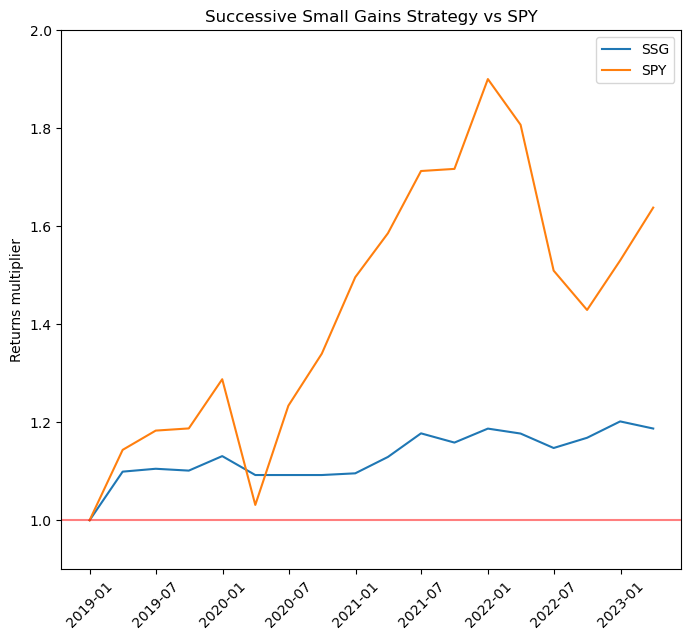

In [151]:
def plot_vs_spy(returns_dict):
    fig, ax = plt.subplots()
    fig.set_size_inches(8,7)
    x = returns_dict.keys()
    y1 = returns_dict.values()
    ax.plot(x,y1, label="SSG")

    spyy = spy.values
    ax.plot(x, spyy, label="SPY")
    
    ax.set_ylim(0.9,2)
    plt.axhline(1, c='r', alpha=0.5)
    
    ax.legend()
    ax.set_ylabel("Returns multiplier")
    ax.set_title("Successive Small Gains Strategy vs SPY")
    plt.xticks(rotation=45)
plot_vs_spy(returns_dict)